In [134]:
import pandas as pd
import numpy as np

import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import plotly.express as px

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import classification_report, silhouette_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

from scipy.stats import chi2_contingency, multinomial
from scipy.sparse import hstack, csr_matrix

import nltk
import re
nltk.download('punkt')
from nltk.tokenize import word_tokenize, RegexpTokenizer, regexp_tokenize, sent_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer, LancasterStemmer, PorterStemmer
from nltk.probability import FreqDist
from nltk import WordNetLemmatizer, pos_tag
from nltk.util import bigrams
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
#nltk.download('all')
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.metrics import BigramAssocMeasures

import itertools
import string
import contractions

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from copy import deepcopy

from xgboost import XGBClassifier

from joblib import parallel_backend

from memory_profiler import profile

from collections import Counter

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/emmascotson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emmascotson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/emmascotson/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/emmascotson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/emmascotson/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Loading the Data

Let's load our dataset and take a look at it.

In [135]:
data = pd.read_csv('data/Combined Data.csv')

In [136]:
data.head()

Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety

In [137]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


Looks like we have some NaNs. Let's take a closer look.

In [138]:
data[pd.isna(data['statement'])]

Unnamed: 0 statement   status
293           293       NaN  Anxiety
572           572       NaN  Anxiety
595           595       NaN  Anxiety
1539         1539       NaN   Normal
2448         2448       NaN   Normal
...           ...       ...      ...
52838       52838       NaN  Anxiety
52870       52870       NaN  Anxiety
52936       52936       NaN  Anxiety
53010       53010       NaN  Anxiety
53031       53031       NaN  Anxiety

[362 rows x 3 columns]

There are so few NaN's compared to the number of rows in our entire dataframe. Furthermore, rows with no 'statement' value are useless to us. Let's drop them.

In [139]:
data = data.dropna(subset=['statement'])

Now let's check if there are duplicate rows. 

In [140]:
data['statement'].nunique()

51073

It looks like there are!

In [141]:
data[data['statement'].duplicated()]

Unnamed: 0                                          statement   status
97             97  "No regrets or grudges/angry at things that ha...  Anxiety
138           138  but my heart is still restless even though my ...  Anxiety
167           167  I want to exhale the restlessness in my chest ...  Anxiety
228           228  Do not compare yourself to others. Envy only m...  Anxiety
244           244  people seem calm, happy like there's no proble...  Anxiety
...           ...                                                ...      ...
53038       53038  Nobody takes me seriously I’ve (24M) dealt wit...  Anxiety
53039       53039  selfishness  "I don't feel very good, it's lik...  Anxiety
53040       53040  Is there any way to sleep better? I can't slee...  Anxiety
53041       53041  Public speaking tips? Hi, all. I have to give ...  Anxiety
53042       53042  I have really bad door anxiety! It's not about...  Anxiety

[1608 rows x 3 columns]

These statements all look pretty specific and personalized. AKA it does seem like our duplicate values are true duplicates of the same social media statements made by the same singular user. Furthermore, we have over 50,000 rows in our dataset and can afford to lose these rows. 

Let's drop duplicates as well.

In [142]:
# Removing 'statement' duplicates, keeping first instance
data = data.drop_duplicates(subset=['statement'], keep='first')

In [143]:
data[data['statement'].duplicated()]

Empty DataFrame
Columns: [Unnamed: 0, statement, status]
Index: []

In [144]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51073 entries, 0 to 52840
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  51073 non-null  int64 
 1   statement   51073 non-null  object
 2   status      51073 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


Furthermore, our 'Unnamed: 0' column appears to just be a duplicate of our index. Let's explore. 

In [145]:
data['Unnamed: 0'].nunique()

51073

In [146]:
# Checking if 'Unnamed: 0' equals our index
is_identical = data['Unnamed: 0'].equals(data.index)
is_identical

False

Hm...We can safely assume this column doesn't provide information about multiple 'statement' values being generated by the same singular user...because our nunique() matches the total number of rows in our dataframe, which eliminates the possibility of duplicates. 

This column is most likely just an old index from previous datasets, which is no longer useful to use. We'll drop it for now. We can always go back and edit the code if we decide we need it later.

In [147]:
data.drop(columns=['Unnamed: 0'], inplace=True)

Let's look at the value_counts() for our target variable 'status'.

In [148]:
data['status'].value_counts()

status
Normal                  16039
Depression              15087
Suicidal                10641
Anxiety                  3617
Bipolar                  2501
Stress                   2293
Personality disorder      895
Name: count, dtype: int64

#### 'Personality disorder'

'Personality disorder' is an ambiguous label compared to the others. It might be a version of a 'placeholder' value for not 'Normal' users where further categorization of disorder (ex. 'Depression', 'Suicidal', 'Anxiety') was inconclusive. Alternatively, it could be indication of other, entirely different personality disorders not listed above. 

We'll keep this in mind and explore as we go. Depending on what we find, it might be helpful to drop these values when building a predictive model.

# Preprocessing & EDA

## Prior to Cleaning...

We'll want to clean the text in our data by performing operations that remove punctuation and special characters, lowercase text, remove newline '\n' characters, etc.

However, ***before*** we do this...let's look at whether or not we can use any of our 'pre-cleaned' text to create features that might be useful down the road.

#### Percentage Upper-Case

Let's think about whether or not any unique punctuation and/or text characteristics might be indicative of a personality disorder. 

*Upper-case* text might help identify whether or not a person is in some kind of distress. If user posts 'A MESSAGE ENTIRELY IN UPPER-CASE LIKE SO', that's an unusual behavior that we should try and quantify.

Let's create a new column 'perc_upper' that calculates the percentage of upper-case letters to the total number of letters in each 'statement'.

In [149]:
# Define function to calculate percentage of upper-case letters
def perc_upper(text):
    if not isinstance(text, str):
        return 0
    letters = re.findall(r'[a-zA-Z]', text) # Using regex to isolate letters
    if not letters: 
        return 0
    upper_count = len(re.findall(r'[A-Z]', text))
    return (upper_count / len(letters)) * 100

data['perc_upper'] = data['statement'].apply(perc_upper)

In [150]:
upper_sorted = data.sort_values(by='perc_upper', ascending=False)
upper_sorted.head()

statement  status  perc_upper
3546  [HELP RT] WE FANBASE SHAKE RP! JOIN? FOLLOW FI...  Normal       100.0
2436                                     ONAKA GA SUITA  Normal       100.0
6787                              TODAY NO CLASS YAAYYY  Normal       100.0
5303  6 HALF HOURS AGAINIII ULULU I ​​WANT TO SLEEP ...  Normal       100.0
2478             I DON'T HAVE A HOLIDAY AS WELL AS EVIL  Normal       100.0

#### METRIC CHANGE - Percentage by Upper-Case Words

On second thought, we should find a different way to quantify a notable amount of upper-case in a string of text. With our current 'perc_upper' value...a statement such as 'Hi' will have a 50% perc_upper. However this would be due to normal grammatical capitalization techniques that are of no note.

Let's alter our metric slightly, to calculate the **percentage of upper-case words compared to the total number of words in a statement**.

We'll stick with regex for now to tokenize our words and calculate this metric.

In [151]:
# Dropping perc_upper column before to reduce computation time
data.drop(columns=['perc_upper'], inplace=True)

# Updating perc_upper to calculate based on number of words
def perc_upper_words(text): 
    if not isinstance(text, str):
        return 0
    words = re.findall(r'\b[a-zA-Z\'-]+\b', text) # Including apostrophes and hyphens
    words = [word for word in words if not re.search(r'\d', word)] # Filter out numbers
    if not words:
        return 0
    uppercase_words = [word for word in words if word.isupper()]
    return len(uppercase_words) / len(words) * 100

data['perc_upper_words'] = data['statement'].apply(perc_upper_words)

In [152]:
upper_sorted = data.sort_values(by='perc_upper_words', ascending=False)
upper_sorted.head()

statement    status  \
11210  I KEEP MESSING THINGS UP ALL DAY EVERY DAY THE...  Suicidal   
5917      #PECAT WHOSE NAME IS SI ALI MOCHTAR NYEBELIN #    Normal   
4173                               OH MY GOD FEAR CANCEL    Normal   
1581   HIS BD CARD KANON IS CUTE HSHSHSHS SAD NO FREE...    Normal   
2811                    YAALLAH SO NATION OF SM DREAMIES    Normal   

       perc_upper_words  
11210             100.0  
5917              100.0  
4173              100.0  
1581              100.0  
2811              100.0

In [153]:
# Sampling rows from the middle
filtered_rows = upper_sorted[(upper_sorted['perc_upper_words'] >= 50.0) & (upper_sorted['perc_upper_words'] <= 60.0)]
filtered_rows.head(20)

statement      status  \
10953    NOBODY WANTS TO TALK TO ME Going to kill myself  Depression   
498    the habit of chatting for a day, gadicchat imm...     Anxiety   
17851  I feel like I cannot even explain myself becau...    Suicidal   
4525                     NOT FUNNY MORNING â€ Runny nose      Normal   
24841  I try my best but I just want to die. I hate m...  Depression   
6357   HAHAAAA GET THE ASSIGNMENT OF MAKING A SCIENTI...      Normal   
1113                     WANT TO SIN BUT Afraid to Laugh      Normal   
36232     Everything is temporary. EVIL EYES OFF SHIVRIT      Normal   
830               MORNING AGAIN I've made a AMENDE SPACE      Normal   
48673  AAAAAAAAAAAAAAAAAA aaAAAAAAAAAA FIDBWJSKLA oaa...      Stress   
4557               if this passes, DROP YOUR LAST COPY !      Normal   
7490   This is what the government wants poor people ...    Suicidal   
19137  I am here to talk if you need help HAHAHAHAA A...  Depression   
22163  I MIGHT KILL MSELF BECAUSE I am A RETARDED USE...    Suicidal   
23744  i just want to fit in. i do not want to be mad...  Depression   
8319   Bitch why the fuck did you just tell me to che...  Depression   
15768  Welp fuck it everything I do gets put on the b...  Depression   
25969  My humiliation and mental torture of sleeping ...    Suicidal   
5121   type IMB space DENITAKOPLOK send to 14045, TON...      Normal   
8227   I really regret talkin or sayin anything. I am...    Suicidal   

       perc_upper_words  
10953         60.000000  
498           60.000000  
17851         60.000000  
4525          60.000000  
24841         59.420290  
6357          57.894737  
1113          57.142857  
36232         57.142857  
830           57.142857  
48673         57.142857  
4557          57.142857  
7490          56.862745  
19137         56.756757  
22163         56.521739  
23744         56.074766  
8319          56.020942  
15768         55.882353  
25969         55.882353  
5121          55.555556  
8227          54.255319

Let's see if there are any trends regarding the distribution of these numbers within each of our 'status' values.

In [154]:
upper_stats = data.groupby('status')['perc_upper_words'].agg(['mean', 'min', 'max'])
upper_stats

mean  min         max
status                                         
Anxiety               5.511061  0.0  100.000000
Bipolar               5.978278  0.0   25.000000
Depression            5.667380  0.0  100.000000
Normal                3.903474  0.0  100.000000
Personality disorder  5.424887  0.0   27.118644
Stress                5.664143  0.0   57.142857
Suicidal              7.922907  0.0  100.000000

Interesting. 'Normal' has the lowest average perc_upper_words with a mean of 3.90, whereas 'Suicidal' has the highest with a mean of 7.92.

Let's see if there are any noticeable trends for the same metric applied to lower-case words. A higher percentage of lower-case words might be indicative of disorders like 'Depression'.

In [155]:
# Updating perc_upper to calculate based on number of words
def perc_lower_words(text): 
    if not isinstance(text, str):
        return 0
    words = re.findall(r'\b[a-zA-Z\'-]+\b', text) # Including apostrophes and hyphens
    words = [word for word in words if not re.search(r'\d', word)] # Filter out numbers
    if not words:
        return 0
    lowercase_words = [word for word in words if word.islower()]
    return len(lowercase_words) / len(words) * 100

data['perc_lower_words'] = data['statement'].apply(perc_lower_words)

In [156]:
lower_stats = data.groupby('status')['perc_lower_words'].agg(['mean', 'min', 'max'])
lower_stats

mean        min    max
status                                           
Anxiety               87.107075   0.000000  100.0
Bipolar               86.984639  25.000000  100.0
Depression            90.887056   0.000000  100.0
Normal                89.098266   0.000000  100.0
Personality disorder  87.738038  45.454545  100.0
Stress                87.853044  14.285714  100.0
Suicidal              87.430360   0.000000  100.0

'Depression' does indeed have the highest mean compared with our other 'status' values. 

However, typing in all lower-case is far more socially "standard" than typing in caps-lock. People often remove automatic capitilization as a setting on their phone or computer, which sets their default text to all lower-case. 

Given that lower-case typing is a societal 'norm', and a personal preference people often make regardless of psychological state...the 'lower_stats' numbers above do not vary drastically between 'status' groups enough for us to be able to use this as a predictive metric. 

We'll drop it and just keep perc_upper_words. 

In [157]:
data.drop(columns=['perc_lower_words'], inplace=True)

#### Special Characters

Let's explore if it will be useful to apply similar logic to special characters and punctuation. Let's examine all the different special characters in our entire dataframe, excluding numbers.

In [158]:
# Searching for special characters, excluding numbers
def extract_special(text):
    if not isinstance(text, str):
        return ''
    return re.findall(r'[^\w\s\d]', text)

special_chars = data['statement'].apply(extract_special).explode().unique()

In [159]:
special_chars

array([nan, ',', '.', "'", '?', ':', ')', '(', '[', ']', '™', '‚', '=',
       '"', '/', '#', '!', '️', '±', '-', '…', '*', '”', '&', '€', '„',
       '«', '–', '¤', '<', '°', '»', '^', ';', '\u200b', '“', '+', '˜',
       '‹', '¥', '©', '£', '@', '~', '¸', '—', '$', '§', '•', '¡', '❤',
       '¨', '>', '‡', '|', '¯', '%', '¦', '{', '}', '’', '\\', '´', '`',
       '†', '¶', '·', '®', '¢', '‰', '¿', '¬', '›', '👩', '\u200d', '🎓',
       '😇', '\u200e', '➡', '💸', '😔', '🙂', '😦', '‘', '💕', '●', '🐰', '🥕',
       '💖', '😱', '😐', '✌', '🏻', '🙃', '☹', '😅', '😢', '😂', '😩', '😖', '↑',
       '👍', '🏼', '😭', '🤷', '♂', '⛅', '🛑', '🤦', '♀', '🙄', '😕', '😠', '😫',
       '😁', '\ufeff', '😒', '💩', '😜', '😨', '😆', '🏽', '😓', '\x80', '\x99',
       '\x9f', '\x98', '\xad', '\x92', '\x8f', '\x8b', '\x9c', '\x9d',
       '\x8d', '\x87', '\x82', '\x8a', '\x81', '\x8c', '\x91', '\x94',
       '\x84', '\x95', '\x96', '\x89', '\x83', '\x88', '\x97', '\x90',
       '\x9a', '\x8e', '\U0001fae0', '🙏', '🔃', '💀', '🤣', '\U0001f

#### Emojis

Let's try and categorize the emojis used. There are few enough that we can manually create lists identifying emojis we deem to carry clear 'positive' or 'negative' sentiments. We'll ignore any "neutral" emojis: we're about to get into more detailed and layered analysis of the actual text in a bit, so we don't need to waste time getting *too* intricate with these additional features!

If we have to choose one or the other, we'll probably choose **negative** emojis as our main predictive metric (with regards to emoji sentiments)...since positive emojis could be used sarcastically. 

The sarcastic use of positive "sentiments" to indicate negativity is far more common than the sarcastic use of negative sentiments to indicate positivity. 

##### Varying Cultural Expression

There can be differences in a person's interpretation and use of emojis when conveying sentiments, based on a variety of cultural factors. We don't know enough about the people who created this dataset, nor do we have demographic information on the users in the dataset itself, to make those determinations...We'll categorize emoji sentiments through our own cultural lens, and see how well our version of this metric helps or hurts our predictive model.

In [160]:
pos_emojis = ['😇', '💖', '🙂', '💕', '❤', '😅', '😂', '👍', '😁', '😆', '🤣', '🥰', '💜', '🤩', '🖤', '😌', '🥲', '🤍','💚','😊',
              '💗', '😍', '🧡', '💝', '♥', '💛', '🤗', '😀', '😹', '😏']

neg_emojis = ['😔', '😦', '😐', '😢', '😩', '😖', '😭', '🤦', '🙄', '😕', '😠', '😫', '😒', '😨', '😓', '😮', '😞', '😳', '😥',
              '😑', '🙁', '😣', '😪', '🤕', '💔']

##### Binary Classification

As we stated, we don't need to get too intricate. Let's create a binary classifier to simply determine whether a 'statement' has any number of positive or negative emojis in it's text. 

In [161]:
# 1 if any positive emojis in 'statement', else 0
def has_pos_emoji(text):
    if not isinstance(text, str):
        return 0
    return 1 if any(emoji in text for emoji in pos_emojis) else 0

data['pos_emoji'] = data['statement'].apply(has_pos_emoji)

In [162]:
# Same for negative emojis
def has_neg_emoji(text):
    if not isinstance(text, str):
        return 0
    return 1 if any(emoji in text for emoji in neg_emojis) else 0

data['neg_emoji'] = data['statement'].apply(has_neg_emoji)

In [163]:
# Define a function to count rows with certain values
def count_rows(df, pos_val, neg_val):
    filtered_df = df[(df['pos_emoji'] == pos_val) & (df['neg_emoji'] == neg_val)]
    return filtered_df.groupby('status').size()

print("Number of Rows with POSITIVE Emojis:")
print(count_rows(data, 1, 0))
print("")
print("Number of Rows with NEGATIVE Emojis:")
print(count_rows(data, 0, 1))
print("")
print("Number of Rows with BOTH:")
print(count_rows(data, 1, 1))

Number of Rows with POSITIVE Emojis:
status
Anxiety                 39
Bipolar                 17
Depression              10
Normal                  15
Personality disorder    22
Stress                   7
dtype: int64

Number of Rows with NEGATIVE Emojis:
status
Anxiety                 40
Bipolar                 12
Depression               8
Personality disorder    14
Stress                  13
dtype: int64

Number of Rows with BOTH:
status
Anxiety                 2
Depression              2
Personality disorder    4
dtype: int64


We were correct in assuming that the use of negative emojis might be a more telling metric than the use of positive emojis. There are no 'Normal' status users that have used any negative emojis whatsoever. The results for positive emojis are more ambiguous. Let's drop that column.

(There are a suprisingly few amount of rows in our dataset that contain emojis. Our neg_emoji column is probably useless as well, but we'll keep it for right now).

In [164]:
data.drop(columns=['pos_emoji'], inplace=True)

#### ! and ?

The last notable special characters we might want to document prior to text cleaning are exclamation points ('!') and question marks ('?'). These are frequently used to convey emotional sentiment, especially distress when used repeatedly (ex. '!!!!!', '????', '!?!?!?!?'). 

Let's add columns counting the number of times a person uses these in a 'statement'.

**Normalization might not be useful here**. Using special characters such as '!' and '?' more than once is already noteworthy, especially in brief statements made on social media. Identifying an excess count, regardless of statement length, is probably our best metric. 

We'll try normalizing first, to see what the numbers look like.

In [165]:
# Function to count characters excluding whitespace and calculate proportion of 'char'
def calculate_char_ratio(text, char):
    if not isinstance(text, str):
        return 0

    # Remove whitespace and count non-whitespace characters
    non_whitespace_text = re.sub(r'\s+', '', text)
    total_characters = len(non_whitespace_text)
    
    # Count occurrences of 'char'
    char_count = text.count(char)
    
    # Calculate proportion
    if total_characters == 0:
        return 0
    ratio = char_count / total_characters
    
    return ratio

# Apply the function to calculate proportions for '!' and '?'
data['exclamation_ratio'] = data['statement'].apply(lambda x: calculate_char_ratio(x, '!'))
data['question_ratio'] = data['statement'].apply(lambda x: calculate_char_ratio(x, '?'))

In [166]:
# Printing stats by 'status' group
exclamation_stats = data.groupby('status')['exclamation_ratio'].agg(['mean', 'min', 'max'])
print("Ratio of Exclamation Points by Status")
exclamation_stats

Ratio of Exclamation Points by Status


mean  min       max
status                                       
Anxiety               0.000642  0.0  0.157895
Bipolar               0.000562  0.0  0.056604
Depression            0.000236  0.0  0.138298
Normal                0.002042  0.0  0.740741
Personality disorder  0.000318  0.0  0.026157
Stress                0.000396  0.0  0.031008
Suicidal              0.000417  0.0  0.246154

In [167]:
question_stats = data.groupby('status')['question_ratio'].agg(['mean', 'min', 'max'])
print("Ratio of Question Marks by Status")
question_stats

Ratio of Question Marks by Status


mean  min       max
status                                       
Anxiety               0.002883  0.0  0.100000
Bipolar               0.003458  0.0  0.090909
Depression            0.001452  0.0  0.166667
Normal                0.005444  0.0  0.466667
Personality disorder  0.003138  0.0  0.062500
Stress                0.001802  0.0  0.210811
Suicidal              0.001741  0.0  0.111111

Interesting. Just like we said, normalizing to account or statement length might not be ideal here. Our non-normalized counts might be easier to interpret. 

Let's run the same for merely the count of each character, not the ratio proportional to the total number of characters in the statement.

In [168]:
# Function to count occurrences of '!'
def count_exclamation(text):
    if not isinstance(text, str):
        return 0
    return text.count('!')

# Add 'exc_count' column to the DataFrame
data['exclamation_count'] = data['statement'].apply(count_exclamation)

# Printing stats by 'status' group
exccount_stats = data.groupby('status')['exclamation_count'].agg(['mean', 'min', 'max'])
print("Exclamation Point Count by Status")
exccount_stats

Exclamation Point Count by Status


mean  min  max
status                                  
Anxiety               0.301355    0   27
Bipolar               0.301479    0    9
Depression            0.110824    0   39
Normal                0.098635    0   20
Personality disorder  0.178771    0   26
Stress                0.176625    0   14
Suicidal              0.116906    0   58

In [169]:
# Function to count occurrences of '!'
def count_question(text):
    if not isinstance(text, str):
        return 0
    return text.count('?')

# Add 'exc_count' column to the DataFrame
data['question_count'] = data['statement'].apply(count_question)

# Printing stats by 'status' group
questcount_stats = data.groupby('status')['question_count'].agg(['mean', 'min', 'max'])
print("Question Mark Count by Status")
questcount_stats

Question Mark Count by Status


mean  min  max
status                                  
Anxiety               1.056953    0   15
Bipolar               1.565374    0   20
Depression            0.652151    0   47
Normal                0.170896    0    8
Personality disorder  1.264804    0   22
Stress                0.648059    0   39
Suicidal              0.616389    0   34

Yes!! These numbers are far more useful, and give us interesting insight that aligns with what we know about personality disorders. It makes a lot of sense that 'Suicidal' would have the highest maximum value of exclamation points...since an excess of exclamation points typically indicates high levels of distress or excitement. It also makes sense that 'Normal' has the lowest maximum value with regards to question mark counts...for similar reasons.

We won't want to jump to concrete conclusions based on personal perception and prior knowledge...we'll trying running our model and see how well these columns actually correlate to and are predictive of 'status'!

We'll keep these two new count features for now and drop our ratio columns. 

In [170]:
data.drop(columns=['exclamation_ratio', 'question_ratio'], inplace=True)

In [171]:
# Checking value_counts to see how useful new columns are
data['question_count'].value_counts()

question_count
0     35919
1      8260
2      3689
3      1627
4       680
5       354
6       212
7       116
8        66
9        39
10       31
11       24
12       12
14        9
16        7
13        7
15        3
17        2
18        2
21        2
19        2
22        2
23        2
20        2
31        1
47        1
34        1
39        1
Name: count, dtype: int64

In [172]:
data['exclamation_count'].value_counts()

exclamation_count
0     47503
1      2237
2       666
3       279
4       164
5        72
6        46
8        27
7        19
9        15
14        7
10        7
12        7
13        5
16        4
11        2
24        2
15        2
20        2
17        1
18        1
58        1
19        1
39        1
26        1
27        1
Name: count, dtype: int64

## Text Cleaning

Now let's clean our text by making everything lower-case, removing special characters, etc.

##### Contractions

We could include a step in our cleaning that prepares our text to analyze contractions (ex. "don't", "aren't", "they're") as *bigrams*. However there aren't any contraction words that are particuarly indicative of sentiment, especially with regards to personality disorders. We want to be detailed, without wasting time - so we will expand our contractions, but won't worry about providing any further analysis on them.

In [173]:
# Expanding contractions
data['statement'] = data['statement'].apply(lambda x: contractions.fix(x))

In [174]:
# Define function to remove emojis
def remove_emojis(text):
    # Regex pattern to match emojis (covers a wide range of emojis)
    emoji_pattern = re.compile(
        '['
        '\U0001F600-\U0001F64F'  # emoticons
        '\U0001F300-\U0001F5FF'  # symbols & pictographs
        '\U0001F680-\U0001F6FF'  # transport & map symbols
        '\U0001F700-\U0001F77F'  # alchemical symbols
        '\U0001F780-\U0001F7FF'  # Geometric Shapes Extended
        '\U0001F800-\U0001F8FF'  # Supplemental Arrows-C
        '\U0001F900-\U0001F9FF'  # Supplemental Symbols and Pictographs
        '\U0001FA00-\U0001FA6F'  # Chess Symbols
        '\U0001FA70-\U0001FAFF'  # Symbols and Pictographs Extended-A
        '\U00002700-\U000027BF'  # Dingbats
        '\U000024C2-\U0001F251' 
        ']+', 
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

# Define function to preprocess text
def clean_text(text):
    if not isinstance(text, str):
        return""
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'[^\w\s]', '', text) # Remove special char's & punct
    text = re.sub(r'\[|\]', '', text)  # Remove square brackets
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = remove_emojis(text) # Apply emoji function from above
    return text

data['cleaned_statement'] = data['statement'].apply(lambda x: clean_text(x))

In [175]:
data.head()

statement   status  \
0                                         oh my gosh  Anxiety   
1  trouble sleeping, confused mind, restless hear...  Anxiety   
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3  I have shifted my focus to something else but ...  Anxiety   
4  I am restless and restless, it is been a month...  Anxiety   

   perc_upper_words  neg_emoji  exclamation_count  question_count  \
0               0.0          0                  0               0   
1               0.0          0                  0               0   
2               0.0          0                  0               0   
3               0.0          0                  0               0   
4               0.0          0                  0               1   

                                   cleaned_statement  
0                                         oh my gosh  
1  trouble sleeping confused mind restless heart ...  
2  all wrong back off dear forward doubt stay in ...  
3  i have shifted my focus to something else but ...  
4  i am restless and restless it is been a month ...

## Tokenization, Stop Words, Lemmatization

Let's tokenize our data, remove stopwords, then use lemmatization. 

### 'Not'

Once we went ahead with tokenization, removal of stopwords, lemmatizaion, and printing a frequency distribution...some of the most-frequent tokens were words such as 'like', 'want' and 'know'...the meaning and interpretation of these words can be drastically altered depending on whether or not the word 'not' comes before them.

Let's alter our code to make sure **'not'** is *excluded* from the stop words we remove. Then we can create ***bigrams*** such as ('not', 'like') and ('not', 'want') that might help us contextualize our tokens more specifically. We'll wait to revisit our bigrams later on.

In [176]:
# Creating list of stop words
stopwords_list = stopwords.words('english')

# Excluding 'not'
important_words = ['not']

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define function to tokenize, remove stopwords, and lemmatize
def tokenize_stopwords_lemmatize(text):
    tokens = word_tokenize(text)
    cleaned_tokens = [w for w in tokens if w not in stopwords_list or w in important_words]
    lemmatized_tokens = [lemmatizer.lemmatize(w) for w in cleaned_tokens]
    return lemmatized_tokens

# Tokenize
data['tokens'] = data['cleaned_statement'].apply(tokenize_stopwords_lemmatize)

In [177]:
data.head()

statement   status  \
0                                         oh my gosh  Anxiety   
1  trouble sleeping, confused mind, restless hear...  Anxiety   
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3  I have shifted my focus to something else but ...  Anxiety   
4  I am restless and restless, it is been a month...  Anxiety   

   perc_upper_words  neg_emoji  exclamation_count  question_count  \
0               0.0          0                  0               0   
1               0.0          0                  0               0   
2               0.0          0                  0               0   
3               0.0          0                  0               0   
4               0.0          0                  0               1   

                                   cleaned_statement  \
0                                         oh my gosh   
1  trouble sleeping confused mind restless heart ...   
2  all wrong back off dear forward doubt stay in ...   
3  i have shifted my focus to something else but ...   
4  i am restless and restless it is been a month ...   

                                              tokens  
0                                         [oh, gosh]  
1  [trouble, sleeping, confused, mind, restless, ...  
2  [wrong, back, dear, forward, doubt, stay, rest...  
3  [shifted, focus, something, else, still, worried]  
4             [restless, restless, month, boy, mean]

# Creating bigrams with 'not'

def bigrams_following_not(tokens):
    bigram_list = list(bigrams(tokens))
    filtered_bigrams = [bigram for bigram in bigram_list if bigram[0] == 'not']
    return filtered_bigrams

data['bigrams_following_not'] = data['tokens'].apply(bigrams_following_not)

# Combine all bigrams across DataFrame
all_bigrams = [bigram for bigram_list in data['bigrams_following_not'] for bigram in bigram_list]

# Remove 'not' from tokens, now that we've made bigrams
def remove_not(tokens):
    return [token for token in tokens if token != 'not']

# Apply function
data['tokens'] = data['tokens'].apply(remove_not)

## Frequency Distribution by 'Status' Group

Let's plot our frequency distributions for each 'status' group, to see which words are most commonly used for each personality disorder. 

We'll want to make use of common bigrams, to see how they compare to our single-word tokens with regards to frequency. We tried combining our tokens with common bigrams and plotting the frequency of both for each status...however our bigrams didn't seem to have as common frequency distribution, and therefore didn't appear on our graphs. 

We'll plot them separately for now, and keep the idea of combining their distributions in the back of our minds.

# Group by 'status' and aggregate tokens
status_groups = data.groupby('status')['tokens'].sum()

# Function to get the most common words for each group
def get_most_common_words(tokens, num_common=10):
    freqdist = FreqDist(tokens)
    return freqdist.most_common(num_common)

# Apply frequency distribution calculation for each status
most_common_words_by_status = status_groups.apply(lambda x: get_most_common_words(x))

#### Normalize Frequency Distribution Counts

Because our dataframe is so large, the code takes quite a while to run. Therefore we decided it's better to test things out, then go back and edit our previous code...to decrease the size and computational runttime of our notebook. 

We tried normalizing our frequency distributions prior to plotting, since we saw in one of the first iterations of this code that they cover a wide range of numbers. We used *log normalization*, since our values cover a wide range and will also be susceptible to outliers.

However, our graphs with log normalization were not very useful to interpret. It might actually be better to get a sense of *how* varied the distribution counts are among words first, *then* normalize if that's helpful.

We will **not** normalize our counts for now. 

# Plotting
# Set up figure and axes
fig, axes = plt.subplots(nrows=7, figsize=(12, 12))

# Empty dict to hold words that have already been plotted and their colors
plotted_words_and_colors = {}
# Establish color palette to pull from
color_palette = sns.color_palette('cividis', n_colors=38)

# Creating a plot for each unique status
status_groups = data.groupby('status')
for idx, (status, status_df) in enumerate(status_groups):
    # Combine all tokens in the current status group
    all_tokens_in_status = status_df['tokens'].explode()
    
    # Calculate frequency distribution
    freq_dist = FreqDist(all_tokens_in_status)
    
    # Get the top 10 tokens and their frequencies
    top_10 = freq_dist.most_common(10)
    tokens, counts = zip(*top_10)
    
    # Select appropriate colors, reusing colors if tokens repeat
    colors = []
    for token in tokens:
        if token not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[token] = new_color
        colors.append(plotted_words_and_colors[token])
    
    # Select axes, plot data, set title
    ax = axes[idx]
    bars = ax.bar(tokens, counts, color=colors)
    ax.set_title(f"Status: {status}")
    
    # Rotate x-axis labels
    ax.set_xticks(tokens)
    ax.set_xticklabels(tokens, rotation=45, ha='right')

fig.tight_layout()
plt.show()

## Dropping Common Tokens

We need to filter our tokens further. We have a lot of overlap of frequent tokens among our status groups which makes sense...tokens such as 'like' are often used as colloquial "filler-words" with no substantial meaning, tokens such as 'get', 'would', and 'know' *could* be useful...but they're also common words used in every-day speech that have no meaning out of context, *especially* when they also appear across all of our status groups.

We need to find a way to identify common tokens specific to a singular status group, that will help us better predict features unique to that status group alone.

Let's define a **threshold** the filters out tokens appearing a certain number of times across all 'statement's in our dataframe. We'll start with 70%, and go from there.

# Combine all tokens across the DataFrame
all_tokens = [token for token_list in data['tokens'] for token in token_list]

# Calculate frequency distribution of all tokens
freq_dist = FreqDist(all_tokens)

# Set a frequency threshold of 70%
threshold = 0.7 * len(data)

# Identify common tokens
common_tokens = {token for token, count in freq_dist.items() if count > threshold}

# Function to remove common tokens
def remove_common_tokens(tokens):
    return [token for token in tokens if token not in common_tokens]

# Apply filtering to the tokens column
data['filtered_tokens'] = data['tokens'].apply(remove_common_tokens)

# Group by 'status' and aggregate filtered tokens
status_groups_filtered = data.groupby('status')['filtered_tokens'].sum()

# Function to get the most common words for each group
def get_most_common_words(tokens, num_common=10):
    freqdist = FreqDist(tokens)
    return freqdist.most_common(num_common)

# Apply frequency distribution calculation for each status
most_common_words_by_status_filtered = status_groups_filtered.apply(lambda x: get_most_common_words(x))

# Set up figure and axes
fig, axes = plt.subplots(nrows=7, figsize=(12, 12))

# Empty dict to hold words that have already been plotted and their colors
plotted_words_and_colors = {}
# Establish color palette to pull from
color_palette = sns.color_palette('cividis', n_colors=38)

# Creating a plot for each unique status
for idx, (status, words_list) in enumerate(most_common_words_by_status_filtered.items()):
    # Get the top words and their frequencies
    top_words = words_list
    words, counts = zip(*top_words)
    
    # Select appropriate colors, reusing colors if words repeat
    colors = []
    for word in words:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    # Select axes, plot data, set title
    ax = axes[idx]
    ax.bar(words, counts, color=colors)
    ax.set_title(f"Status: {status}")
    
    # Rotate x-axis labels
    ax.set_xticks(range(len(words)))
    ax.set_xticklabels(words, rotation=45, ha='right')

fig.tight_layout()
plt.show()

This did seem to help a bit. For example, 'pain' was added to our top 10 most-common words for users with 'Anxiety', which is far more useful than the word 'like'. 

However we still have a lot of overlap. Let's adjust our threshold further and try 60%. We can always go back and adjust.

# Set a frequency threshold of 60%
threshold = 0.6 * len(data)

# Identify common tokens
common_tokens = {token for token, count in freq_dist.items() if count > threshold}

# Function to remove common tokens
def remove_common_tokens(tokens):
    return [token for token in tokens if token not in common_tokens]

# Apply filtering to the tokens column
data['filtered_tokens'] = data['tokens'].apply(remove_common_tokens)

# Group by 'status' and aggregate filtered tokens
status_groups_filtered = data.groupby('status')['filtered_tokens'].sum()

# Function to get the most common words for each group
def get_most_common_words(tokens, num_common=10):
    freqdist = FreqDist(tokens)
    return freqdist.most_common(num_common)

# Apply frequency distribution calculation for each status
most_common_words_by_status_filtered = status_groups_filtered.apply(lambda x: get_most_common_words(x))

# Set up figure and axes
fig, axes = plt.subplots(nrows=7, figsize=(12, 12))

# Empty dict to hold words that have already been plotted and their colors
plotted_words_and_colors = {}
# Establish color palette to pull from
color_palette = sns.color_palette('cividis', n_colors=38)

# Creating a plot for each unique status
for idx, (status, words_list) in enumerate(most_common_words_by_status_filtered.items()):
    # Get the top words and their frequencies
    top_words = words_list
    words, counts = zip(*top_words)
    
    # Select appropriate colors, reusing colors if words repeat
    colors = []
    for word in words:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    # Select axes, plot data, set title
    ax = axes[idx]
    ax.bar(words, counts, color=colors)
    ax.set_title(f"Status: {status}")
    
    # Rotate x-axis labels
    ax.set_xticks(range(len(words)))
    ax.set_xticklabels(words, rotation=45, ha='right')

fig.tight_layout()
plt.show()

Super helpful! Notice how 'anymore' was added to 'Suicidal', and 'friend' was added to 'Personality disorder'.

Let's try it one more time, and go quite extreme. We tried filtering again to 50%, and it didn't make much of a difference. Let's set our threshold at 35% as an experiment and see what happens.

# Set a frequency threshold of 35%
threshold = 0.35 * len(data)

# Identify common tokens
common_tokens = {token for token, count in freq_dist.items() if count > threshold}

# Function to remove common tokens
def remove_common_tokens(tokens):
    return [token for token in tokens if token not in common_tokens]

# Apply filtering to the tokens column
data['filtered_tokens'] = data['tokens'].apply(remove_common_tokens)

# Group by 'status' and aggregate filtered tokens
status_groups_filtered = data.groupby('status')['filtered_tokens'].sum()

# Function to get the most common words for each group
def get_most_common_words(tokens, num_common=10):
    freqdist = FreqDist(tokens)
    return freqdist.most_common(num_common)

# Apply frequency distribution calculation for each status
most_common_words_by_status_filtered = status_groups_filtered.apply(lambda x: get_most_common_words(x))

# Set up figure and axes
fig, axes = plt.subplots(nrows=7, figsize=(12, 12))

# Empty dict to hold words that have already been plotted and their colors
plotted_words_and_colors = {}
# Establish color palette to pull from
color_palette = sns.color_palette('cividis', n_colors=38)

# Creating a plot for each unique status
for idx, (status, words_list) in enumerate(most_common_words_by_status_filtered.items()):
    # Get the top words and their frequencies
    top_words = words_list
    words, counts = zip(*top_words)
    
    # Select appropriate colors, reusing colors if words repeat
    colors = []
    for word in words:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    # Select axes, plot data, set title
    ax = axes[idx]
    ax.bar(words, counts, color=colors)
    ax.set_title(f"Status: {status}")
    
    # Rotate x-axis labels
    ax.set_xticks(range(len(words)))
    ax.set_xticklabels(words, rotation=45, ha='right')

fig.tight_layout()
plt.show()

Super interesting and potentially very useful!

## Bigrams

Let's revisit bigrams. We kept the stop word 'not' in our tokens, in order to see whether it's particularly useful in defining the sentiment of a following word in a bigram. 

We can furthermore calculate the **Raw Frequency** of bigrams with other tokens in our dataset as well as the **Pointwise Mutual Information Score** between bigram pairs in our dataset. Mutual Information Score essentially tells us the mutual dependence between two words. 

We can then determine whether any other bigram pairs are important. 

We'll perform this on our original 'tokens' column, rather than the lists of tokens filtered with thresholds. There may be some very common words that become unique to a particular status, when paired with another token in a bigram!

### Filtering out Noise

It might be helpful to filter out pairs of words that occur frequently across our entire dataset, regardless of 'status' group. The same way we eliminate stop words from our tokens prior to drawing any meaningful conclusions.

By first filtering out the most frequent bigrams in our dataset, we can help eliminate unecessary noise.

To improve computational efficiency, we ran some code already and have some interesting takeaways that we can apply here prior to re-running...which will make our results more useful and improve run-times. 

We ran code filtering through the raw frequencies and PMI scores for the top 50 bigrams in the entire dataset, as well as by status group

### 'Not' and 'Like'

Our main takeaways are regarding the words **not** and **like**. 

#### Like

As we mentioned earlier, **like** is a pretty useless filler word that's only important if it's conveying some type of sentiment in it's verb form ("to like"). Once we looked at the most common bigrams, we found this was *not* the case in our dataset 

Ex. If the bigrams had included phrases such as ('i', 'like') or ('not', 'like') or ('you', 'like') in relation to specific 'status' groups, they might have been useful in predicting a person's mental state). These pairings did **not** appear in our results, so we can safely *drop the token 'like' from our entire dataframe*. 

In [178]:
# Remove 'like' from tokens, now that we've made bigrams
def remove_like(tokens):
    return [token for token in tokens if token != 'like']

# Apply function
data['tokens'] = data['tokens'].apply(remove_like)

#### Not

Our results related to **not** were more nuanced. Some bigrams containing 'not' definitely *do* convey interesting and informative sentiments...however they appear so frequently across our entire dataframe, *and* all or most of our 'status' groups...that they really will not be helpful predicting specific personality disorders. 

We carefully filtered through the raw frequencies and PMI scores for the top 50 bigrams in the entire dataset, as well as by status group...and we retrieved certain 'not' bigrams that we think will be useful to include. Some were found frequently across multiple 'status' groups in our dataset, that might still be informative when breaking down their frequency counts by status in a further filtered dataframe...others were meaningful bigrams found frequently in individual 'status' groups alone.

There's a list of our selects below.

In [179]:
# List of bigrams to keep
bigrams_to_keep = [('could', 'not'), ('not', 'stop'), ('not', 'able'), ('not', 'help'), ('not', 'take'), ('not', 'seem'), ('not', 'work'), 
                   ('life', 'not'), ('not', 'see'), ('people', 'not'), ('not', 'anything'), ('not', 'understand'), ('not', 'good'), ('not', 'going'), 
                   ('not', 'sleep'), ('not', 'afford'), ('anymore', 'not'), ('die', 'not'), ('not', 'anymore'), ('would', 'not')]

We're running into problems with accidentally creating or removing duplicate tokens, which might be a problem when we get to count vectorization shortly. 

We'll create additional lists below, which will help us determine whether to drop 'not' as a token from our 'tokens' list...while preserving the structure of all other tokens in the row. 

In [180]:
# Remove 'like' from tokens, now that we've made bigrams
def remove_not(tokens):
    return [token for token in tokens if token != 'not']

# Apply function
data['tokens'] = data['tokens'].apply(remove_not)

# words where 'not' is second word in bigram selects
not_second = ['could', 'life', 'people', 'anymore', 'die', 'would']

# words where 'not' is first word in bigram selects
not_first = ['stop', 'able', 'help', 'take', 'seem', 'work', 'see', 'anything', 'understand', 'good', 'going', 'sleep',
             'afford', 'anymore']

import nltk
from nltk.util import bigrams

# Define function to remove 'not' tokens based on conditions
def remove_not(tokens, not_first):
    # Convert tokens to bigrams
    bigram_list = list(bigrams(tokens))
    
    # Determine indices of 'not' to remove
    remove_not_indices = set()
    
    # Identify indices where 'not' should be removed
    for i, bigram in enumerate(bigram_list):
        if bigram[0] == 'not' and bigram[1] not in not_first:
            # If 'not' is the first word and the second word is NOT in 'not_first', mark 'not' for removal
            remove_not_indices.add(i)
        elif bigram[0] == 'not' and bigram[1] in not_first:
            # If 'not' is the first word and the second word is in 'not_first', keep 'not'
            # Remove index from removal set if it exists
            remove_not_indices.discard(i)
    
    # Create a new list of tokens excluding the 'not' tokens that are to be removed
    filtered_tokens = [token for i, token in enumerate(tokens) if not (token == 'not' and (i-1) in remove_not_indices)]
    
    return filtered_tokens

# Apply the function to the DataFrame
data['tokens'] = data['tokens'].apply(lambda x: remove_not(x, not_first))

# Verify the changes
data.head()

Now we run our code calculating the frequency and PMI scores for bigrams by 'status', with our filtered data.

#### Raw Frequency by Status

# Define a function to score bigrams
def score_bigrams(tokens):
    bigram_finder = BigramCollocationFinder.from_words(tokens)
    bigrams_scored = bigram_finder.score_ngrams(BigramAssocMeasures.raw_freq)
    return bigrams_scored[:50]  # Return top 30 scored bigrams

# Group by 'status' and apply the scoring function
bigrams_by_status = data.groupby('status')['tokens'].apply(lambda x: score_bigrams(x.sum()))

# Print or access the results for each status
for status, bigrams in bigrams_by_status.items():
    print(f"Status: {status}")
    for idx, (bigram, score) in enumerate(bigrams, 1):
        print(f"{idx}. {bigram}: {score}")
    print()

#### Mutual Information Score by Status

bigram_measures = BigramAssocMeasures()

# Define a function to score bigrams using PMI
def score_bigrams(tokens):
    bigram_finder = BigramCollocationFinder.from_words(tokens)
    bigram_finder.apply_freq_filter(20)  # Higher filter for larger dataframe
    bigrams_scored = bigram_finder.score_ngrams(bigram_measures.pmi)
    return bigrams_scored

# Group by 'status' and apply the scoring function
bigrams_by_status = data.groupby('status')['tokens'].apply(lambda x: score_bigrams(sum(x, [])))

# Print or access the results for each status
for status, bigrams in bigrams_by_status.items():
    print(f"Status: {status}")
    for idx, (bigram, score) in enumerate(bigrams[:50], 1):  # Print top 30
        print(f"{idx}. {bigram}: {score}")
    print()

There is a lot of really fascinating and informative findings in our exploration of bigrams. 

For example, 'Anxiety' users appear to speak about physical health ailments and concerns (such as brain tumors, lymph nodes, heart attacks), which makes a lot of sense. 'Bipolar' users speak in 'up & down', 'high & low', 'mood swings'...which also makes sense. 'Depression' users conjure "downward" imagery of 'rock bottom', 'rabbit hole', etc. 

This is all super helpful!

# Combining tokens and bigrams
def combine_tokens_bigrams(row):
    tokens = row['tokens']
    bigrams = row['bigrams_following_not']
    return tokens + bigrams

data['combined_tokens_bigrams'] = data.apply(combine_tokens_bigrams, axis=1)

# Group by status and aggregate
status_groups = data.groupby('status')['combined_tokens_bigrams'].sum()

# Vectorization

Let's move ahead with our train test split and begin vectorization of a model.

We'll use **TF-IDF** vectorization, and we'll compare token frequencies not only to their total frequencies across documents/'statement' values...but across entire 'status' groups as well. 

Let's make a new dataframe 'filtered_df', that extracts only the necessary features we need for our models.

In [181]:
data.head()

statement   status  \
0                                         oh my gosh  Anxiety   
1  trouble sleeping, confused mind, restless hear...  Anxiety   
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3  I have shifted my focus to something else but ...  Anxiety   
4  I am restless and restless, it is been a month...  Anxiety   

   perc_upper_words  neg_emoji  exclamation_count  question_count  \
0               0.0          0                  0               0   
1               0.0          0                  0               0   
2               0.0          0                  0               0   
3               0.0          0                  0               0   
4               0.0          0                  0               1   

                                   cleaned_statement  \
0                                         oh my gosh   
1  trouble sleeping confused mind restless heart ...   
2  all wrong back off dear forward doubt stay in ...   
3  i have shifted my focus to something else but ...   
4  i am restless and restless it is been a month ...   

                                              tokens  
0                                         [oh, gosh]  
1  [trouble, sleeping, confused, mind, restless, ...  
2  [wrong, back, dear, forward, doubt, stay, rest...  
3  [shifted, focus, something, else, still, worried]  
4             [restless, restless, month, boy, mean]

In [182]:
columns_to_keep = ['status', 'perc_upper_words', 'neg_emoji', 'exclamation_count', 'question_count', 'tokens']
filtered_df = data.loc[:, columns_to_keep]
filtered_df.head()

status  perc_upper_words  neg_emoji  exclamation_count  question_count  \
0  Anxiety               0.0          0                  0               0   
1  Anxiety               0.0          0                  0               0   
2  Anxiety               0.0          0                  0               0   
3  Anxiety               0.0          0                  0               0   
4  Anxiety               0.0          0                  0               1   

                                              tokens  
0                                         [oh, gosh]  
1  [trouble, sleeping, confused, mind, restless, ...  
2  [wrong, back, dear, forward, doubt, stay, rest...  
3  [shifted, focus, something, else, still, worried]  
4             [restless, restless, month, boy, mean]

In [183]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51073 entries, 0 to 52840
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   status             51073 non-null  object 
 1   perc_upper_words   51073 non-null  float64
 2   neg_emoji          51073 non-null  int64  
 3   exclamation_count  51073 non-null  int64  
 4   question_count     51073 non-null  int64  
 5   tokens             51073 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 2.7+ MB


### Filtering for Empty Tokens

After all of our preprocessing and cleaning...we might have some rows that are essentially "empty", with 0 tokens. This could happen if a person's statement included only stop words, emoticons, punctuation, etc. 

We'll filter for these and set them to NaN. If there are relatively few, compared to the 51,000+ rows we currently have in our dataframe, we can feel good about simply dropping them. 

In [184]:
# Set rows with empty 'tokens' lists to NaN
filtered_df.loc[filtered_df['tokens'].apply(lambda x: len(x) == 0), 'tokens'] = np.nan

# Optional: Print the DataFrame to verify
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51073 entries, 0 to 52840
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   status             51073 non-null  object 
 1   perc_upper_words   51073 non-null  float64
 2   neg_emoji          51073 non-null  int64  
 3   exclamation_count  51073 non-null  int64  
 4   question_count     51073 non-null  int64  
 5   tokens             50955 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 2.7+ MB


In [185]:
# Dropping NaNs
filtered_df = filtered_df.dropna(subset=['tokens'])

# Multinomial Naive Bayes Classifier

For our first model, we'll try a mulltinomial naive bayes classifier. This type of model deals with text data alone, so we'll leave the other numeric features we added out of this train test split.

### Train Test Split and Vectorize

In [186]:
# Convert token lists to strings
filtered_df['joined_tokens'] = filtered_df['tokens'].apply(lambda x: ' '.join(x))

# Define features and target
X = filtered_df['joined_tokens']
y = filtered_df['status']  # 'status' is the target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

### GridSearchCV

We can either vectorize our singular tokens as unigrams, or include bigrams in our analysis. 

Furthermore, our dataset is larger so a higher number of max_features might be better.

We can test the best parameters for our model using GridSearchCv

#### Check for Class Imbalance

Before we fit our model, we'll need to handle class imbalance.

In [187]:
# Assuming `y_train` contains the target labels
class_distribution = y_train.value_counts(normalize=True)
class_distribution

status
Normal                  0.307895
Depression              0.300998
Suicidal                0.208843
Anxiety                 0.071885
Bipolar                 0.048419
Stress                  0.044438
Personality disorder    0.017523
Name: proportion, dtype: float64

#### Large Dataset - Class Imbalance, Feature Importance

Because our dataset is larger, we'll try to account for class imbalance by adjusting the class weights with the MultinomialNB 'class_prior'. 

We'll also want to optimize computational runttimes, by narrowing our feature selection if possible...We tried using **SelectKBest** with a **chi-squared** test. This would evaluate the statistical importace of each feature, by measuring the independence between a feature and target variable.

SelectKBest would be the most suitable option for a model like Multinomial Naive Bayes. We'll look at other tree-based models and options for feature selection in a bit.

However, our scores were even *worse*, so we'll remove SelectKbest from our Pipeline for now.

In [188]:
# Set class prior probabilities based on class distribution
class_prior = [0.307895, 0.300998, 0.208843, 0.071885, 0.048419, 0.044438, 0.017523]

In [189]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'tfidf__max_features': [10000, 20000],  # Number of features to use in the TF-IDF Vectorizer
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Use unigrams and/or bigrams
    'feature_selection__k': [1000, 5000, 'all'],
    'clf__alpha': [0.1, 0.5, 1.0],  # Smoothing parameter for Naive Bayes
    'clf__fit_prior': [True, False]  # Whether to learn class prior probabilities or use the ones provided
}

# Create a pipeline that first transforms data using TF-IDF and then applies Naive Bayes
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Placeholder for TF-IDF Vectorizer
    ('feature_selection', SelectKBest(score_func=chi2)),
    ('clf', MultinomialNB(class_prior=class_prior))  # Naive Bayes with class priors
])

# Initialize GridSearchCV with timeout for joblib workers
timeout_in_seconds = 300  # Timeout set to 5 minutes (300 seconds)
with parallel_backend('loky'):
    grid_search = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=5,  # Number of folds for cross-validation
        scoring='f1_weighted',  # F1 score, weighted for imbalanced classes
        verbose=1,  # Print progress
        n_jobs=-1  # Use all available cores
    )

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # After fitting, now you can access best parameters and scores
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best F1 score: {grid_search.best_score_}")

    # Evaluate on the test set
    best_model = grid_search.best_estimator_
    test_score = best_model.score(X_test, y_test)
    print(f"Test set score: {test_score}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'clf__alpha': 0.1, 'clf__fit_prior': True, 'feature_selection__k': 'all', 'tfidf__max_features': 20000, 'tfidf__ngram_range': (1, 2)}
Best F1 score: 0.4304857142867046
Test set score: 0.46588604696801206


In [190]:
# Assuming best_model is your best estimator from GridSearchCV
tfidf_vectorizer = best_model.named_steps['tfidf']
X_train_tfidf = tfidf_vectorizer.transform(X_train)

# Inspect the shape of the transformed feature matrix
print(f"Shape of X_train_tfidf: {X_train_tfidf.shape}")

Shape of X_train_tfidf: (35668, 20000)


Classification Report:
                       precision    recall  f1-score   support

             Anxiety       0.33      0.85      0.47      1053
             Bipolar       0.23      0.78      0.36       774
          Depression       0.46      0.80      0.58      4350
              Normal       0.94      0.38      0.54      4944
Personality disorder       0.82      0.27      0.41       270
              Stress       0.70      0.12      0.20       708
            Suicidal       0.88      0.03      0.06      3188

            accuracy                           0.47     15287
           macro avg       0.62      0.46      0.37     15287
        weighted avg       0.70      0.47      0.42     15287



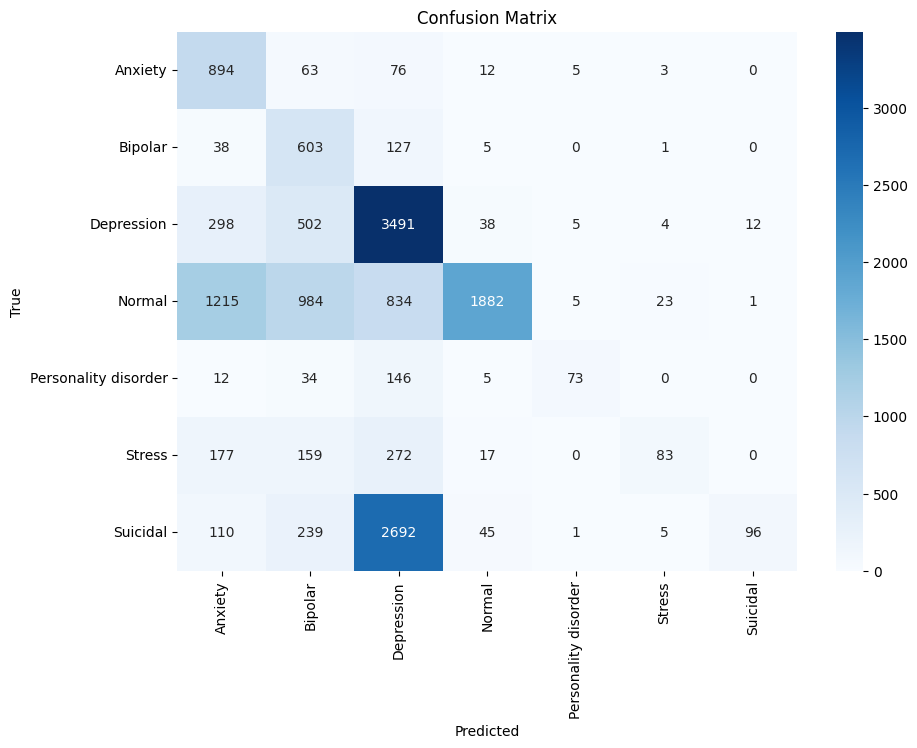

In [191]:
# Generate predictions on the test set
y_pred = best_model.predict(X_test)

# Print classification report
report = classification_report(y_test, y_pred, target_names=best_model.classes_)
print("Classification Report:\n", report)

# Optionally, print confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

These scores are not very good. Which is okay! We shall continue tuning!

Stress and Suicidal cases seem particularly hard to accurately predict, with lower f1-scores. We will keep this in mind as we tune and test other models...in case this seems to be a trend. 

We can come back to this model and tune it to yield better results...but first let's test some other models and see if they perform better as a baseline.

Before we move on, let's see whether there's any informative results on feature importance or irrelevancy, that we can highlight and compare with other models...We moved ahead and tried running other models like *XGBoost*, however they unsurprisingly didn't reach convergence due to extraneous computational runtimes. This makes sense, because our dataset is currently so large and complex with 7 target variables. We need to figure out how to narrow things down if possible.

We can trying **making lists of most and least important features across models**...then we can cross-reference using these lists and figure out which tokens to drop and which to keep as we hone in on feature selection.

## Feature Importance - MultinomialNB

Multinomial Bayes doesn't extract feature importance like some of our other predictive models...but we can still get some good idea of feature relevancy using log probabilities and extracting feature names. This will tell us the log of the probability that a particular word ends up in a feature class.

We'll have to extract from SelectKBest

# Accessing the TfidfVectorizer and SelectKBest from the pipeline
tfidf_vectorizer = best_model.named_steps['tfidf']
select_k_best = best_model.named_steps['feature_selection']  # Assuming 'feature_selection' is the name of SelectKBest step

# Getting feature names (words) from TfidfVectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get indices of selected features from SelectKBest
selected_feature_indices = select_k_best.get_support(indices=True)

# Accessing MultinomialNB classifier from the pipeline
clf = best_model.named_steps['clf']

# Getting the log probabilities of features given each class
log_probabilities = clf.feature_log_prob_

# Determine top and bottom features for all classes combined and store in combined lists
top_n = 50  # Number of top and bottom features to consider

multinomialnb_top_features = set()  # Using set to ensure uniqueness
multinomialnb_bottom_features = set()

for i, class_label in enumerate(clf.classes_):
    # Filter log_probabilities and feature_names with selected_feature_indices
    class_log_probabilities = log_probabilities[i, selected_feature_indices]
    class_feature_names = [feature_names[idx] for idx in selected_feature_indices]

    # Sort indices based on log probabilities
    top_features_idx = np.argsort(class_log_probabilities)[::-1][:top_n]
    bottom_features_idx = np.argsort(class_log_probabilities)[:top_n]

    # Retrieve top and bottom features
    top_features = [class_feature_names[idx] for idx in top_features_idx]
    bottom_features = [class_feature_names[idx] for idx in bottom_features_idx]

    # Extend sets with top and bottom features
    multinomialnb_top_features.update(top_features)
    multinomialnb_bottom_features.update(bottom_features)

# Convert sets back to lists
multinomialnb_top_features = list(multinomialnb_top_features)
multinomialnb_bottom_features = list(multinomialnb_bottom_features)

multinomialnb_top_features

multinomialnb_bottom_features

# Print top 20 and bottom 20 features for each class individually
for i, class_label in enumerate(clf.classes_):
    # Filter log_probabilities and feature_names with selected_feature_indices
    class_log_probabilities = log_probabilities[i, selected_feature_indices]
    class_feature_names = [feature_names[idx] for idx in selected_feature_indices]

    # Sort indices based on log probabilities
    top_features_idx = np.argsort(class_log_probabilities)[::-1][:20]
    bottom_features_idx = np.argsort(class_log_probabilities)[:20]

    # Retrieve top and bottom features
    top_features = [class_feature_names[idx] for idx in top_features_idx]
    bottom_features = [class_feature_names[idx] for idx in bottom_features_idx]

    print(f"Top 20 features for class '{class_label}':")
    print(top_features)
    print()

    print(f"Bottom 20 features for class '{class_label}':")
    print(bottom_features)
    print()

##### Dropping - 'know', 'told', 'might', 'feel'

Already from these, we can gain some valuable insight into features we can drop. Although these selections were made by log probabilities, which don't directly tell us a certain correlation or impact a feature might have on predicting a given class...we can highlight some repetetive features that add nothing but noise to our data. 

**'know'** and **'told'** are two that might be helpful to drop. We'll keep these for now, since there's a *chance* they might implicate a unique mental state (ex. 'know' can help us determine whether or not a person feels grounded in reality 'i know', or lost 'i don't know'...'told' could help implicate whether someone feels unheard 'i told', or attacked 'they told me!'...it's unlikely we'll need them but we'll run some more models before coming to any concrete conclusion). 

**'feel'** can be dropped. It's been appearing as one of the most frequently used tokens in all of our outputs regarding feature/token importance...which makes sense given that this dataset is exploring internal emotional states of users. Furthermore, 'feel' doesn't give us any further insight...because whatever word follows it (ex 'i feel **stressed**', 'i feel **happy**', 'i feel **worried**') is the actually informative word, *and* will implicate the verb "to feel". 

**'might'** can also be dropped. It's a filler word that doesn't seem to be operating in bigrams in a way that helpfully implicates emotional uncertainty. There will be other more unique ways to determine uncertainty of mental state by class if necessary.

In [192]:
# Remove 'like' from tokens, now that we've made bigrams
def remove_feel(tokens):
    return [token for token in tokens if token != 'feel']

def remove_might(tokens):
    return [token for token in tokens if token!= 'might']

# Apply function
data['tokens'] = data['tokens'].apply(remove_feel)
filtered_df['tokens'] = filtered_df['tokens'].apply(remove_feel)

data['tokens'] = data['tokens'].apply(remove_might)
filtered_df['tokens'] = filtered_df['tokens'].apply(remove_might)

# Set rows with empty 'tokens' lists to NaN
filtered_df.loc[filtered_df['tokens'].apply(lambda x: len(x) == 0), 'tokens'] = np.nan

# Optional: Print the DataFrame to verify
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50955 entries, 0 to 52840
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   status             50955 non-null  object 
 1   perc_upper_words   50955 non-null  float64
 2   neg_emoji          50955 non-null  int64  
 3   exclamation_count  50955 non-null  int64  
 4   question_count     50955 non-null  int64  
 5   tokens             50953 non-null  object 
 6   joined_tokens      50955 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 3.1+ MB


In [193]:
# Dropping NaNs
filtered_df = filtered_df.dropna(subset=['tokens'])

# Convert token lists to strings
filtered_df['joined_tokens'] = filtered_df['tokens'].apply(lambda x: ' '.join(x))

# Feature Selection

We need to continue to hone and select our most important features, in order to hopefully build models with better scores that are less computationally expensive. 

# Multinomial Logistic Regression

Let's see how multinomial logistic regression performs as a model, and extract relevant features like we did for Multinomial Naive Bayes.

We'll deal with **class imbalance** by adjusting our **class weight hyperparameter**, rather than using a technique like SMOTE.

### Including Numeric Features

We'll be able to include the numeric features we calculated earlier on, in addition to our vectorized text data.

### LabelEncoder()

We'll need to use labelencoder() to encode our target variable classes, so they are integer values that the model can interpret.

X = filtered_df.drop(columns=['status', 'tokens'])
y = filtered_df['status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)
y_train = pd.Series(y_train_encoded)
y_test = pd.Series(y_test_encoded)

# Check encoded labels
print("Encoded y_train:")
print(y_train.value_counts())

print("Encoded y_test:")
print(y_test.value_counts())

# Mapping from encoded labels to original labels
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Label Mapping:")
print(label_mapping)

vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 2))

X_train_text = vectorizer.fit_transform(X_train['joined_tokens'])
X_test_text = vectorizer.transform(X_test['joined_tokens'])

# Scale numeric data
# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform StandardScaler on numeric data
X_train_numeric_scaled = scaler.fit_transform(X_train[['perc_upper_words', 'neg_emoji', 'exclamation_count', 'question_count']])
X_test_numeric_scaled = scaler.transform(X_test[['perc_upper_words', 'neg_emoji', 'exclamation_count', 'question_count']])

X_train_combined = hstack([X_train_text, X_train_numeric_scaled])
X_test_combined = hstack([X_test_text, X_test_numeric_scaled])

### Feature Importance - SelectFromModel, Random Forest

To minimize computational expense, we need to hone our feature selection in our model once again. Instead of using SelectKBest this time with a chi-squared test, let's use **SelectFromModel** paired with **RandomForestClassifier()** to select predictive features. 

We'll use Random Forest as opposed to Grandient Boosting, since our dataset is quite large and Gradient Boosting might be more computationally expensive.

# Example param_grid for GridSearchCV with SelectFromModel
param_grid = {
    'select__threshold': ['mean', 'median', '2.*mean'],
    'clf__C': [0.1, 1.0, 10.0],
    'clf__solver': ['lbfgs', 'saga'],
    'clf__max_iter': [2000], # Balance computational cost with covergence needs for max_iter
}

# Example pipeline with SelectFromModel and Logistic Regression
pipeline = Pipeline([
    ('select', SelectFromModel(estimator=RandomForestClassifier())),
    ('clf', LogisticRegression(class_weight='balanced', random_state=42)), # Removed multi_class to account for warning, multinomial is default
])

# Initialize GridSearchCV
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5,
    scoring='f1_weighted',
    verbose=0,
    n_jobs=-1,
)

# Fit GridSearchCV
grid_search.fit(X_train_combined, y_train)

# Evaluate on the test set
test_score = grid_search.score(X_test_combined, y_test)
print(f"Test set score: {test_score}")

print("Best parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

## Convergence Errors

We've run our logistic regression model many times now, and continue to get errors regarding our max_iterations. We've tried multiple values, yet it seems this model might not be working. Our dataset is pretty large and complex, so logistic regression might simply not be the best model.

We'll leave the code in here as markdowns, in case it's helpful to refer back to at some point. There's no use having it run unecessarily everytime we run our notebook.

# Modifying our Dataset

We've continue to run into some pretty serious issues with this dataset, as we've attempted to run different models. To eliminate computational cost, we have not included all of the iterations of the models we ran. After carefully and thoroughly tuning hyperparameters, adjusting feature selection, etc. for Multionomial Naive Bayes, Multinomial Logistic Regression, Random Forest, and XGBoost...it's clear that our dataset is currently formatted in a way that will either yield poor model results *or* result in errors and model failure. 

Our **dataset is currently very large and complex**, with 7 different subcategories of our main target variable that we are trying to predict from 50,000 rows of vectorized text data. 

If we had more time, we could invest in fine tuning these complex models further and relying on more machine learning resources and programs that would allow our models to run with these complex structures. *However*, we have a deadline to complete for this particular project, and furthermore upon reviewing our dataset it's current formatting might not be the most optimal anyway. 

## Reassessing our Target Status Groups

Let's examine our 7 different 'status' groups. This is a lot of groups to predict, which creates the need more complex feature engineering on top of greater computational expense. Most importantly, we noticed there are some overlaps among the group 'statement' values, that might make it hard to accurately predict all 7 groups. AKA...it seems like our data might not be categorized specifically enough to yield great models as is.

Take a look at these selections 50 **statement values from *Anxiety* and from *Stress***...

In [194]:
# Filter rows where 'status' is 'Anxiety' and get the 'statement' values
anxiety_statements = data.loc[data['status'] == 'Anxiety', 'statement'].head(50)

# Print the first 50 statements
for idx, statement in enumerate(anxiety_statements):
    print(f"Statement {idx + 1}: {statement}")

Statement 1: oh my gosh
Statement 2: trouble sleeping, confused mind, restless heart. All out of tune
Statement 3: All wrong, back off dear, forward doubt. Stay in a restless and restless place
Statement 4: I have shifted my focus to something else but I am still worried
Statement 5: I am restless and restless, it is been a month now, boy. What do you mean?
Statement 6: every break, you must be nervous, like something is wrong, but what the heck
Statement 7: I feel scared, anxious, what can I do? And may my family or us be protected :)
Statement 8: Have you ever felt nervous but did not know why?
Statement 9: I have not slept well for 2 days, it is like I am restless. why huh :([].
Statement 10: I am really worried, I want to cry.
Statement 11: always restless every night, even though I do not know why, what is wrong. strange.
Statement 12: I am confused, I am not feeling good lately. Every time I want to sleep, I always feel restless
Statement 13: sometimes what is needed when there i

In [195]:
# Filter rows where 'status' is 'Anxiety' and get the 'statement' values
stress_statements = data.loc[data['status'] == 'Stress', 'statement'].head(50)

# Print the first 50 statements
for idx, statement in enumerate(stress_statements):
    print(f"Statement {idx + 1}: {statement}")

Statement 1: He said he had not felt that way before, suggeted I go rest and so ..TRIGGER AHEAD IF YOUI'RE A HYPOCONDRIAC LIKE ME: i decide to look up "feelings of doom" in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy, a stupid "are you psychic" test or new age b.s., something I could even laugh at down the road. No, I ended up reading that this sense of doom can be indicative of various health ailments; one of which I am prone to.. So on top of my "doom" to my gloom..I am now f'n worried about my heart. I do happen to have a physical in 48 hours.
Statement 2: My mom then hit me with the newspaper and it shocked me that she would do this, she knows I do not like play hitting, smacking, striking, hitting or violence of any sort on my person. Do I send out this vibe asking for it from the universe? Then yesterday I decided to take my friend to go help another "friend" move to a new place. While we were driving the friend we are moving strikes me on my shoul

Take a look at some of these examples from the *Stress* statements printed above...

**Statement 15**: The sensation lasted hours. It seemed like a circulation problem, and I panicked and of course ended up in the ER again. This time a doctor came to see me immediately. He wanted to talk about my anxiety. He said he could run some more tests, but he did not think it would help.

**Statement 10**: Everything sets me off and I am almost having a panic attack. I am going to my dads soon and that also makes me anxious because I am afraid that I am not in the mental state to go there...

**Statement 11**: I have been taking 12.5 mgs zoloft for about 6 months (yeah, super small dose .. but it was taking the edge off, i think). I decided to stop taking it for a few days to see if it was really helping. Now, about 40 hours since my last dose, I am suddenly kind of shaky and also flushed...

Furthermore, a lot of the Stress statements seem to be talking about physical illness, ailments, emergencies, etc. If we remember back to our most important **bigrams in Anxiety**, they seemed to point to very similar discussions of physical health. 

# Stress VS. Anxiety

According to the American Psychological Association, stress and anxiety can present with quite similar symptoms...however stress is a temporary state due to external circumstances, whereas anxiety lasts even after external stressors resolve. 

Furthermore, **stress can be a symptom of anxiety**. 

In other contexts, it might be useful to make the distinctions between the two. However for our agenda...if a user is in a state of emotional disturbance and stress severe enough that they turn to a chatbot for mental health resources...it will be reasonable (at least for these initial notebook algorithms) to refer them to the underlying mood disorder most commonly associated with stress...anxiety. 

We'll combine these under *Anxiety*. 

(There are other mood-disorders and psychological conditions that can present as symptoms of stress...such as the manic episodes associated with Bi-Polar, or symptoms of PTSD. Given our examination of the 'statement' values categorized as stress, we feel comfortable assuming the 'stress' identified in this dataset is more closely related to anxiety...However we want to acknowledge that ***before any next steps are taken to develop software from these models, and before any actual medical or psychological advice is given to real human subjects, these metrics should be thoroughly re-evaluated.***

# Depression VS. Suicidal

Let's examine some statement selects from *Depression* and *Suicidal*. These are more noticeably distinct compared with Stress and Anxiety -- as *Suicidal* implies a very specific threat of action that neither Depression, Anxiety, nor Stress do...However we'll double check to make sure this specificty of distinction is relatively clear in our statements.

In [196]:
# Filter rows where 'status' is 'Anxiety' and get the 'statement' values
depression_statements = data.loc[data['status'] == 'Depression', 'statement'].head(50)

# Print the first 50 statements
for idx, statement in enumerate(depression_statements):
    print(f"Statement {idx + 1}: {statement}")

Statement 1: I recently went through a breakup and she said she still wants to be friends so I said I can try doing that but when she talks to me about things it always hurts. I just want to lose feelings so all this pain can stop it hurts so much and I cannot even cry about it. I do not want to hurt her because she said she does not want to never speak to me again but I do not know what to do here. When we were together she always hurt me so I do not know why I still love her. I wish we never met it would be much less painful How do I lose feelings?
Statement 2: I do not know how to navigate these feelings, not that its a new feeling by any stretch. I just do not understand how I can go on from being so pleasantly fine to suicidal and self loathing within in minutes and not be able to step out of it. I have been suffering from poor mental health for over 10 years and I am about to turn 26 next week and I feel so ashamed for how serious my negative thoughts are. Covid was a hard transi

In [197]:
# Filter rows where 'status' is 'Anxiety' and get the 'statement' values
suicidal_statements = data.loc[data['status'] == 'Suicidal', 'statement'].head(50)

# Print the first 50 statements
for idx, statement in enumerate(suicidal_statements):
    print(f"Statement {idx + 1}: {statement}")

Statement 1: I am so exhausted of this. Just when I think I can finally rest, just when I think maybe things are starting to settle, another hurdle comes flying at me. This month alone we found out my mum could be dying, my girlfriend left me, my parents revealed that they wanted a divorce, my grandad was hospitalised again and just now my little sister's been rushed to A&amp;E with possible brain damage. If there is a god up there they must fucking hate me. it is like life is trying to get me to kill myself and honestly I think I would be better off dead. I attempted when I was 12 but I was stupid and there was no way I could cut deep enough. Now I am 15 and everything is so much worse than it ever has been and I just cannot hold on much longer -- it is going to take a miracle to get me through this. I feel so alone. I feel like the world hates me and I have no idea what I did wrong to deserve this. I thought I was getting better. I was doing so well and now everything's just come cra

It does seem like there is a much clearer distinction between 'Suicidal' and 'Depression' than there was between Stress and Anxiety.

Let's quickly examine whether or not any of our 'Depression' rows might be mislabeled. We don't know how these datasets were initially integrated and classified.

In [198]:
# Example tokens to check for
tokens = ['suicide', 'suicidal', 'kill']

# Filter rows where 'status' is 'Depression' and 'statement' contains any token
filtered_rows = data[(data['status'] == 'Depression') & 
                            (data['statement'].str.contains('|'.join(tokens), case=False, na=False))]

In [199]:
filtered_rows

statement      status  \
6983   I do not know how to navigate these feelings, ...  Depression   
6996   I am going to make this short because i hate t...  Depression   
6999   I have been talking to someone who I really li...  Depression   
7004   Not because of death, but because she wanted t...  Depression   
7015   I have not seen my 7 year old daughter in a co...  Depression   
...                                                  ...         ...   
48038  It is getting worse 19F, I have been strugglin...  Depression   
48045  Tried commiting suicide twice today failed mis...  Depression   
48051  I feel like I was not meant to be born (litera...  Depression   
48058  I hate this phrase People always jump to say, ...  Depression   
48059  Everytime I think of my "future" I just think,...  Depression   

       perc_upper_words  neg_emoji  exclamation_count  question_count  \
6983           9.539474          0                  0               0   
6996           4.249292          0                  0               2   
6999          11.627907          0                  0               2   
7004           6.852792          0                  0               2   
7015           2.380952          0                  0               0   
...                 ...        ...                ...             ...   
48038          2.958580          0                  0               0   
48045          3.658537          0                  0               0   
48051          1.575931          0                  0               0   
48058          9.433962          0                  0               4   
48059          7.500000          0                  0               8   

                                       cleaned_statement  \
6983   i do not know how to navigate these feelings n...   
6996   i am going to make this short because i hate t...   
6999   i have been talking to someone who i really li...   
7004   not because of death but because she wanted to...   
7015   i have not seen my  year old daughter in a cou...   
...                                                  ...   
48038  it is getting worse f i have been struggling w...   
48045  tried commiting suicide twice today failed mis...   
48051  i feel like i was not meant to be born literal...   
48058  i hate this phrase people always jump to say s...   
48059  everytime i think of my future i just think ma...   

                                                  tokens  
6983   [know, navigate, feeling, new, feeling, stretc...  
6996   [going, make, short, hate, thinking, long, sto...  
6999   [talking, someone, really, liked, great, perso...  
7004   [death, wanted, get, awayi, depressed, year, m...  
7015   [seen, year, old, daughter, couple, month, mov...  
...                                                  ...  
48038  [getting, worse, f, struggling, depression, ye...  
48045  [tried, commiting, suicide, twice, today, fail...  
48051  [meant, born, literally, tw, mention, sexual, ...  
48058  [hate, phrase, people, always, jump, say, suic...  
48059  [everytime, think, future, think, maybe, km, w...  

[3113 rows x 8 columns]

Holy moly! That's a lot! Let's remove 'kill' (our intention was to isolate rows with anything similar to 'kill myself' in the statement, however with the amount of rows that were returned we'll have to get more specific) and try again...

In [200]:
# Example tokens to check for
tokens = ['suicide', 'suicidal']

# Filter rows where 'status' is 'Depression' and 'statement' contains any token
filtered_rows = data[(data['status'] == 'Depression') & 
                            (data['statement'].str.contains('|'.join(tokens), case=False, na=False))]

filtered_rows

statement      status  \
6983   I do not know how to navigate these feelings, ...  Depression   
6996   I am going to make this short because i hate t...  Depression   
6999   I have been talking to someone who I really li...  Depression   
7040   I am 19 male. Both of my parents where immigra...  Depression   
7044   I no longer look forward to ANYTHING. I have a...  Depression   
...                                                  ...         ...   
48030  I have been struggling with depression for aro...  Depression   
48037  another episode is suddenly hitting me and i d...  Depression   
48045  Tried commiting suicide twice today failed mis...  Depression   
48051  I feel like I was not meant to be born (litera...  Depression   
48058  I hate this phrase People always jump to say, ...  Depression   

       perc_upper_words  neg_emoji  exclamation_count  question_count  \
6983           9.539474          0                  0               0   
6996           4.249292          0                  0               2   
6999          11.627907          0                  0               2   
7040           7.500000          0                  0               2   
7044          11.347518          0                  0               0   
...                 ...        ...                ...             ...   
48030          9.743590          0                  0               0   
48037          8.673469          1                  0               1   
48045          3.658537          0                  0               0   
48051          1.575931          0                  0               0   
48058          9.433962          0                  0               4   

                                       cleaned_statement  \
6983   i do not know how to navigate these feelings n...   
6996   i am going to make this short because i hate t...   
6999   i have been talking to someone who i really li...   
7040   i am  male both of my parents where immigrants...   
7044   i no longer look forward to anything i have a ...   
...                                                  ...   
48030  i have been struggling with depression for aro...   
48037  another episode is suddenly hitting me and i d...   
48045  tried commiting suicide twice today failed mis...   
48051  i feel like i was not meant to be born literal...   
48058  i hate this phrase people always jump to say s...   

                                                  tokens  
6983   [know, navigate, feeling, new, feeling, stretc...  
6996   [going, make, short, hate, thinking, long, sto...  
6999   [talking, someone, really, liked, great, perso...  
7040   [male, parent, immigrant, dad, died, car, acci...  
7044   [longer, look, forward, anything, beautiful, g...  
...                                                  ...  
48030  [struggling, depression, around, year, know, m...  
48037  [another, episode, suddenly, hitting, want, wi...  
48045  [tried, commiting, suicide, twice, today, fail...  
48051  [meant, born, literally, tw, mention, sexual, ...  
48058  [hate, phrase, people, always, jump, say, suic...  

[1790 rows x 8 columns]

In [201]:
# Print the first 50 statements
for idx, statement in enumerate(filtered_rows['statement'].head(50), start=1):
    print(f"Statement {idx}: {statement}")

Statement 1: I do not know how to navigate these feelings, not that its a new feeling by any stretch. I just do not understand how I can go on from being so pleasantly fine to suicidal and self loathing within in minutes and not be able to step out of it. I have been suffering from poor mental health for over 10 years and I am about to turn 26 next week and I feel so ashamed for how serious my negative thoughts are. Covid was a hard transition especially having moved to a new city a few months before everything started locking down, but now I am here and settled and I have a loving partner, a great connection to their family, a really fun job and I finished my degree. But when I stop and look around I feel like nothing will ever be good enough for me and I will never be good enough, I will always have skin problems and bad teeth and acne. I will never be the artist I used to be (I have a Bachelor in fine art) because I do not have the same drive or passionate that I used to have for it

Wow! It seems like these are all mislabeled! Jeez Louise!

Let's run the value counts on our data to see how much this will alter our class imbalance.

In [202]:
filtered_df['status'].value_counts()

status
Normal                  15924
Depression              15086
Suicidal                10637
Anxiety                  3617
Bipolar                  2501
Stress                   2293
Personality disorder      895
Name: count, dtype: int64

We will change all of these to 'Suicidal'.

## Word Count -- Feature Selection

Upon closer examination of these statement values, it's become clear that certain posts have a far higher word count than others. Furthermore, higher word counts seem to be associated with long tangents of vented distress. 

Maybe we should add a word_count column that counts the number of words in each statement, and see whether or not there's any clear difference in the distribution of numbers by status that might help us better predict our target variables.

In [203]:
filtered_df.head()

status  perc_upper_words  neg_emoji  exclamation_count  question_count  \
0  Anxiety               0.0          0                  0               0   
1  Anxiety               0.0          0                  0               0   
2  Anxiety               0.0          0                  0               0   
3  Anxiety               0.0          0                  0               0   
4  Anxiety               0.0          0                  0               1   

                                              tokens  \
0                                         [oh, gosh]   
1  [trouble, sleeping, confused, mind, restless, ...   
2  [wrong, back, dear, forward, doubt, stay, rest...   
3  [shifted, focus, something, else, still, worried]   
4             [restless, restless, month, boy, mean]   

                                       joined_tokens  
0                                            oh gosh  
1  trouble sleeping confused mind restless heart ...  
2  wrong back dear forward doubt stay restless re...  
3         shifted focus something else still worried  
4                   restless restless month boy mean

In [204]:
# Function to calculate word count
def count_words(text):
    return len(text.split())

# Apply word count function to 'statement' column
data['word_count'] = data['statement'].apply(count_words)

# Group by 'status' and calculate mean, max, min word count
grouped_data = data.groupby('status')['word_count'].agg(['mean', 'max', 'min'])

print("Mean, Max, Min Word Count by Status:")
print(grouped_data)

Mean, Max, Min Word Count by Status:
                            mean   max  min
status                                     
Anxiety               148.093724  1673    1
Bipolar               184.722111  4850    4
Depression            168.955326  4245    1
Normal                 17.914646   264    1
Personality disorder  184.788827  5580    5
Stress                115.350632  1648    3
Suicidal              146.726811  6300    2


Wow! ***Huge*** difference with regards to 'Normal' users VS. users with a mood disorder. Let's add this to our filtered_df.

In [205]:
filtered_df['word_count'] = data['word_count']

# Dropping 'Personality Disorder'

Lastly, 'Personality Disorder' is an entirely unhelpful label. We have no idea what this means or how to harness domain knowledge to engineer feature selects that might help us predict 'Personality Disorder' as an outcome. There's a strong possibility it overlaps with our other status groups.

We kept this group in our dataframe, in case our exploration of relevant tokens/bigrams, and running subsequent models, helped us understand what kind of condition it's meant to label...however we've found no new useful information and our models are having trouble running. Since this is such a small portion of our dataset, we can drop it entirely. 

Furthermore, combining certain status groups, and dropping others that are improperly labeled and in the minority class **might help with the class imbalances which are potentially affecting the success of our model attempts**.

## Applying Changes

In [206]:
# Drop rows where 'status' is 'Personality disorder'
filtered_df = filtered_df[filtered_df['status'] != 'Personality disorder']

In [207]:
# Relabeling stress as anxiety
filtered_df.loc[filtered_df['status'] == 'Stress', 'status'] = 'Anxiety'

In [208]:
# Relabeling depression rows that should be suicidal
# Step 1: Filter rows where status is 'Depression' and tokens contain 'suicide' or 'suicidal'
filtered_rows = filtered_df[(filtered_df['status'] == 'Depression') & 
                            (filtered_df['tokens'].apply(lambda x: 'suicide' in x or 'suicidal' in x))]

# Step 2: Update status to 'Suicidal' for these filtered rows
filtered_df.loc[filtered_rows.index, 'status'] = 'Suicidal'

In [209]:
filtered_df['status'].value_counts(normalize=True)

status
Normal        0.318111
Depression    0.266451
Suicidal      0.247413
Anxiety       0.118063
Bipolar       0.049962
Name: proportion, dtype: float64

This seriously helped improve the class imbalance in our model! 

Let's try our models that had problems running, and see if things go more smoothly now. 

# Numeric Feature Evaluation - Random Forest

Our models are still not running properly -- it's a lot of data to deal with! 

We have those numeric features that we've engineered...Let's use random on our numeric features only to hone in on feature selection and drop irrelevant numeric columns. Then we can limit the number of features in our more complex models once we combine our numeric and vectorized text data. 

In [210]:
X = filtered_df.drop(columns=['status', 'tokens'])
y = filtered_df['status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


X_train_numeric = X_train[['perc_upper_words', 'neg_emoji', 'exclamation_count', 'question_count', 'word_count']].values
X_test_numeric = X_test[['perc_upper_words', 'neg_emoji', 'exclamation_count', 'question_count', 'word_count']].values

param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
}

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced')),
])

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1_weighted',
    verbose=0,
    n_jobs=-1,
)

# Fit GridSearchCV
grid_search.fit(X_train_numeric, y_train)

# Evaluate on the test set
test_score = grid_search.score(X_test_numeric, y_test)
print(f"Test set score: {test_score}")

print("Best parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

/opt/anaconda3/envs/learn-env-3.9/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

### Visualizing Numeric Features by Importance

In [ ]:
# Access the best estimator (fitted RandomForestClassifier) from grid_search
best_rf_model = grid_search.best_estimator_.named_steps['clf']

# Get feature importances
importances = best_rf_model.feature_importances_

# Create a DataFrame for easier plotting
feature_importance_df = pd.DataFrame({
    'Feature': ['perc_upper_words', 'neg_emoji', 'exclamation_count', 'question_count', 'word_count'],
    'Importance': importances
})

# Sort features by importance (optional)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, hue='Feature', palette='coolwarm', dodge=False, legend=False)
plt.title('Feature Importances for Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#### Further Numeric Feature Evaluation - Correlation 

Our added word_count feature was clearly a success compared to our other features! Let's compare these results with correlation coefficients between our numeric features and each class of our target variable, using Multinomial Logistic Regression. 

In [ ]:
# Prepare X and y
X = filtered_df.drop(columns=['status', 'tokens'])
y = filtered_df['status']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder on y and transform it
y_encoded = label_encoder.fit_transform(y)

# Now 'y_encoded' contains numerical labels for your categories
# Print the mapping of original labels to encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:")
print(label_mapping)

In [ ]:
# Assign encoded target variable to y
y = y_encoded

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Select numeric features
numeric_features = ['perc_upper_words', 'neg_emoji', 'exclamation_count', 'question_count', 'word_count']
X_train_numeric = X_train[numeric_features]

# Calculate correlation coefficients with each category in y_train_series
correlation_coefficients = {}
for category in np.unique(y_train_series):
    category_mask = (y_train_series == category)
    if np.sum(category_mask) > 0:  # Check if there are samples for this category
        correlations = X_train_numeric.corrwith(pd.Series(y_train_series[category_mask]))
        correlation_coefficients[category] = correlations
    else:
        print(f"No samples found for category {category}. Skipping correlation calculation.")

# Print correlation coefficients for each category
for category, correlations in correlation_coefficients.items():
    category_name = label_encoder.inverse_transform([category])[0]  # Convert encoded category back to original label
    print(f"Correlation coefficients for category '{category_name}':")
    print(correlations)
    print("\n")

In [ ]:
# Check for missing values in X_train_numeric
missing_values = X_train_numeric.isnull().sum()
print("Missing values in X_train_numeric:\n", missing_values)

In [ ]:
# Check for constant columns in X_train_numeric
constant_columns = X_train_numeric.columns[X_train_numeric.nunique() == 1]
print("Constant columns in X_train_numeric:\n", constant_columns)

In [ ]:
# Check variance of numeric features
feature_variances = X_train_numeric.var()
print("Variance of numeric features:\n", feature_variances)

In [ ]:
# Check data types and alignment
print("X_train_numeric shape:", X_train_numeric.shape)
print("y_train shape:", y_train.shape)

In [ ]:
# Convert y_train from numpy array to pandas Series
y_train_series = pd.Series(y_train)

# Now you can check the distribution of y_train categories
print("Distribution of y_train categories:")
print(y_train_series.value_counts())

In [ ]:
# Tried Kendall and Spearman to try and debug, problem splitting y_train into classes
# Trying Pearson again after troubleshooting without splitting y_train

# Select numeric features
numeric_features = ['perc_upper_words', 'neg_emoji', 'exclamation_count', 'question_count', 'word_count']
X_train_numeric = X_train[numeric_features]

# Convert y_train to a pandas Series
y_train_series = pd.Series(y_train, index=X_train.index)

# Calculate correlation coefficients with the target variable y_train
correlation_coefficients = X_train_numeric.corrwith(y_train_series)

# Print correlation coefficients
print("Correlation coefficients with y_train:\n")
print(correlation_coefficients)

In [ ]:
# Tried Kendall and Spearman, problem splitting y_train into classes
# Trying Pearson again after troubleshooting
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize LabelEncoder for target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Convert y_train_encoded back to a Series with original index
y_train_series = pd.Series(y_train_encoded, index=X_train.index)

# Select numeric features
numeric_features = ['perc_upper_words', 'neg_emoji', 'exclamation_count', 'question_count', 'word_count']
X_train_numeric = X_train[numeric_features]

# Category labels (e.g., 0, 1, 2, 3, 4)
categories = [0, 1, 2, 3, 4]

# Calculate and print Pearson correlation coefficients for each category
for category in categories:
    category_mask = (y_train_series == category)
    correlations_pearson = X_train_numeric[category_mask].corrwith(y_train_series[category_mask], method='pearson')
    
    # Convert category to its name or label (if applicable)
    category_name = label_encoder.inverse_transform([category])[0]  # Adjust as per your label encoding
    
    # Print correlation coefficients for the current category
    print(f"Pearson correlation coefficients for category '{category_name}':")
    print(correlations_pearson)
    print("\n")

Oh well. Not helpful. We need to move forward rather than wasting more time. 

# Numeric Feature Evaluation - Multinomial Logistic Regression

Let's run logistic regression on our numeric features only, while we're still evaluating them. In case comparing these scores happens to be helpful to us later on.

In [ ]:
# Prepare X and y
X = filtered_df.drop(columns=['status', 'tokens'])
y = filtered_df['status']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Select numeric features
numeric_features = ['perc_upper_words', 'neg_emoji', 'exclamation_count', 'question_count', 'word_count']
X_train_numeric = X_train[numeric_features]
X_test_numeric = X_test[numeric_features]

# Initialize StandardScaler and fit on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric) 

# Define parameter grid for Logistic Regression
param_grid = {
    'clf__C': [0.1, 1.0, 10.0, 100.0],  # Regularization parameter
    'clf__solver': ['lbfgs', 'saga'],  # Multinomial Logistic Regression solvers
    'clf__max_iter': [500, 1000, 1500],  # Maximum number of iterations
}

# Setup the pipeline with Logistic Regression
pipeline = Pipeline([
    ('clf', LogisticRegression(class_weight='balanced', random_state=42)),
])

# Perform Grid Search CV with f1_weighted as scoring metric
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1_weighted',  # Use f1_weighted for grid search scoring
    verbose=0,
    n_jobs=-1,
)

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)  # Use X_train_scaled here

# Evaluate on the test set
test_score = grid_search.score(X_test_scaled, y_test)  # Use X_test_scaled here
print(f"Test set score (F1 weighted): {test_score}")

# Print best parameters and best F1 weighted score
print("Best parameters:", grid_search.best_params_)
print("Best F1 weighted score:", grid_search.best_score_)

# Optionally, print classification report
y_pred = grid_search.predict(X_test_scaled)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Printing stats by 'status' group
exccount_stats = filtered_df.groupby('status')['exclamation_count'].agg(['mean', 'min', 'max'])
print("Exclamation Point Count by Status")
exccount_stats

In [ ]:
wordcount_stats = filtered_df.groupby('status')['word_count'].agg(['mean', 'min', 'max'])
wordcount_stats

# Text Feature Evaluation - Narrowing Down

Before we try to run anymore models again, we clearly need to cut down on the amount of text data in the form of tokens that we're running through our models as features.

We've spent hours and hours and hours trying to troubleshoot these models to get them to work prior to making any big cuts to our dataset...but it's clearly not working. It's time to get bold and vicious! Make some serious cuts just to see what happens. We're going to take the liberate to experiment. We can always go back and edit our code later on and undo what we did. 

# Multinomial Naive Bayes

Our only model that properly ran with our text data was Multinomial Naive Bayes. Let's run it again and use it cut out a ton of words that have very low probabilities of fitting into any of our 5 target categories. 

First, let's see how many tokens we actually have. So we can get a sense of how many we should drop.

In [211]:
# Step 1: Flatten the lists in 'tokens' column
flat_list = [item for sublist in filtered_df['tokens'] for item in sublist]

# Step 2: Count unique strings
unique_strings_count = len(set(flat_list))

print(f"Number of unique strings across the dataset: {unique_strings_count}")

Number of unique strings across the dataset: 74412


That is a freaking ton! No wonder our models are getting overwhelmed. 

To jog our memories...here were our scores from the first time we ran Multinomial Naive Bayes as a baseline model.

#### Baseline Scores

Fitting 5 folds for each of 72 candidates, totalling 360 fits

*Best parameters*: {'clf__alpha': 0.1, 'clf__fit_prior': True, 'feature_selection__k': 'all', 'tfidf__max_features': 20000, 'tfidf__ngram_range': (1, 2)}

*Best F1 score*: 0.4304857142867046

*Test set score*: 0.46588604696801206

Shape of X_train_tfidf: (35668, 20000)

    Classification Report:
                           precision    recall  f1-score   support

                 Anxiety       0.33      0.85      0.47      1053
                 Bipolar       0.23      0.78      0.36       774
              Depression       0.46      0.80      0.58      4350
                  Normal       0.94      0.38      0.54      4944
    Personality disorder       0.82      0.27      0.41       270
                  Stress       0.70      0.12      0.20       708
                Suicidal       0.88      0.03      0.06      3188

                accuracy                           0.47     15287
               macro avg       0.62      0.46      0.37     15287
            weighted avg       0.70      0.47      0.42     15287

#### Class Imbalance - Class Prior

If we remember back to our original model, we had to account for class imbalance using class_prior. However, now that we've tuned our dataset, our class imbalances are different. We'll need to rerun those numbers.

In [212]:
# Define features and target
X = filtered_df['joined_tokens']
y = filtered_df['status']  # 'status' is the target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Assuming `y_train` contains the target labels
class_distribution = y_train.value_counts(normalize=True)
class_distribution

status
Normal        0.315554
Depression    0.266667
Suicidal      0.250171
Anxiety       0.118493
Bipolar       0.049115
Name: proportion, dtype: float64

#### Select Features

Now's the time to be bold! We'll set limits on our Vectorizer, as well as our SelectKBest. 

In [213]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=20000)  # Limit vocabulary size to 10000
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Feature Selection using SelectKBest with chi2 score
k_best = 10000  # Select top 5000 features
selector = SelectKBest(score_func=chi2, k=k_best)
X_train_selected = selector.fit_transform(X_train_tfidf, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'clf__alpha': 0.1, 'clf__fit_prior': True, 'tfidf__ngram_range': (1, 2)}
Best F1 score: 0.4932794230060484
Test set score: 0.5135171127979757
Shape of X_train_tfidf: (35040, 20000)
Classification Report:
               precision    recall  f1-score   support

     Anxiety       0.37      0.76      0.50      1758
     Bipolar       0.34      0.79      0.47       780
  Depression       0.46      0.79      0.58      3994
      Normal       0.94      0.40      0.56      4867
    Suicidal       0.92      0.19      0.31      3619

    accuracy                           0.51     15018
   macro avg       0.61      0.58      0.49     15018
weighted avg       0.71      0.51      0.49     15018



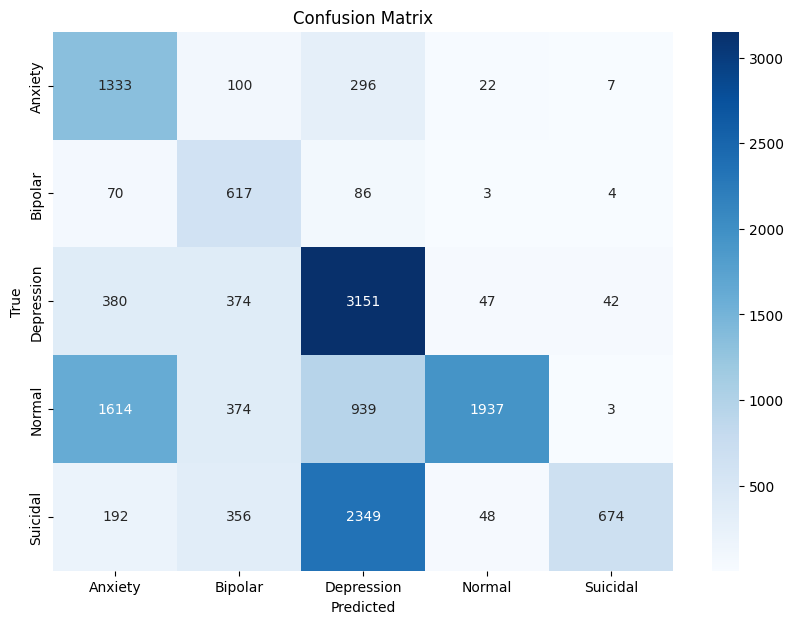

In [214]:
# Define class priors
class_priors = [0.315554, 0.266667, 0.250171, 0.118493, 0.049115]

# Define the parameter grid for GridSearchCV
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Use unigrams and/or bigrams
    'clf__alpha': [0.1, 0.5, 1.0],  # Smoothing parameter for Naive Bayes
    'clf__fit_prior': [True]  # Whether to learn class prior probabilities or use the ones provided
}

# Create a pipeline that first transforms data using TF-IDF and then applies Naive Bayes
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000)),  # Placeholder for TF-IDF Vectorizer
    ('feature_selection', SelectKBest(score_func=chi2, k=10000)),
    ('clf', MultinomialNB(class_prior=class_priors))  # Naive Bayes with class priors
])

# Initialize GridSearchCV with timeout for joblib workers
timeout_in_seconds = 300  # Timeout set to 5 minutes (300 seconds)
with parallel_backend('loky'):
    grid_search = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=5,  # Number of folds for cross-validation
        scoring='f1_weighted',  # F1 score, weighted for imbalanced classes
        verbose=1,  # Print progress
        n_jobs=-1  # Use all available cores
    )

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # After fitting, now you can access best parameters and scores
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best F1 score: {grid_search.best_score_}")

    # Evaluate on the test set
    best_model = grid_search.best_estimator_
    test_score = best_model.score(X_test, y_test)
    print(f"Test set score: {test_score}")

# Assuming best_model is your best estimator from GridSearchCV
tfidf_vectorizer = best_model.named_steps['tfidf']
X_train_tfidf = tfidf_vectorizer.transform(X_train)

# Inspect the shape of the transformed feature matrix
print(f"Shape of X_train_tfidf: {X_train_tfidf.shape}")

# Generate predictions on the test set
y_pred = best_model.predict(X_test)

# Print classification report
report = classification_report(y_test, y_pred, target_names=best_model.classes_)
print("Classification Report:\n", report)

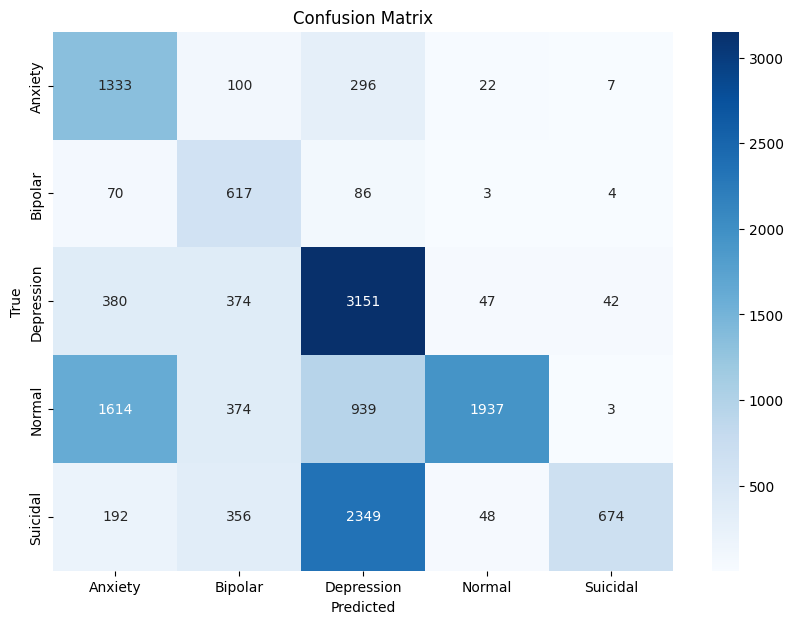

In [216]:
# Optionally, print confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Save the plot with transparent background
plt.savefig('multi_naive_bays_confusion_matrix.png', transparent=True)

plt.show()

These scores are marginally better, but any improvement is hopeful! 

This confusion matrix is super, super interesting...There are still a lot of 'Depression' cases being incorrectly predicted as 'Suicidal'. 

There are also a lot of 'Anxiety' cases being incorrectly predicted as 'Normal', and quite a bit of 'Depression' cases being incorrectly predicted as normal as well.

Let's explore the overlap in tokens and bigrams among these categories. 

## Depression VS. Suicidal

In [ ]:
filtered_df.head()

In [217]:
# Function to tokenize and extract n-grams
def extract_ngrams(text, ngram_range=(1, 1)):
    vectorizer = CountVectorizer(ngram_range=ngram_range, analyzer='word')
    X = vectorizer.fit_transform(text)
    feature_names = vectorizer.get_feature_names_out()
    return feature_names

# Filter data to include only 'Depression' and 'Suicidal' statuses
dep_suic = filtered_df[filtered_df['status'].isin(['Depression', 'Suicidal'])]

# Extract unigrams (tokens) for Depression
tokens_depression_unigrams = extract_ngrams(dep_suic[dep_suic['status'] == 'Depression']['joined_tokens'], ngram_range=(1, 1))

# Extract bigrams for Depression
bigrams_depression = extract_ngrams(dep_suic[dep_suic['status'] == 'Depression']['joined_tokens'], ngram_range=(1, 2))

# Extract unigrams (tokens) for Suicidal
tokens_suicidal_unigrams = extract_ngrams(dep_suic[dep_suic['status'] == 'Suicidal']['joined_tokens'], ngram_range=(1, 1))

# Extract bigrams for Suicidal
bigrams_suicidal = extract_ngrams(dep_suic[dep_suic['status'] == 'Suicidal']['joined_tokens'], ngram_range=(1, 2))

# Find common tokens and bigrams
common_tokens = set(tokens_depression_unigrams).intersection(tokens_suicidal_unigrams)
common_bigrams = set(bigrams_depression).intersection(bigrams_suicidal)

# Print the number of common tokens and bigrams
print(f"Number of common tokens (unigrams) between 'Depression' and 'Suicidal': {len(common_tokens)}")
print("Common tokens (unigrams):", common_tokens)

print(f"Number of common bigrams between 'Depression' and 'Suicidal': {len(common_bigrams)}")
print("Common bigrams:", common_bigrams)

Number of common tokens (unigrams) between 'Depression' and 'Suicidal': 15704
Common tokens (unigrams): {'hangover', 'bless', 'animal', 'shorted', 'playing', 'deductible', 'remembered', 'realizes', 'trolled', 'painmy', 'wayy', 'separating', 'excess', 'politics', 'gen', 'extensively', 'afghanistan', 'forty', 'dehydration', 'guessi', 'recommend', 'phantom', 'tooth', 'preform', 'com', 'disney', 'becayse', 'celibate', 'magic', 'slope', 'lifebut', 'raising', 'shave', 'praising', 'shortened', 'hypothesis', 'traumatized', 'ket', 'scrambled', 'dismissive', 'intervention', 'tug', 'selfishly', 'dreadful', 'deteriorates', 'forced', 'harmed', 'pile', 'martyr', 'excruciating', 'pristiq', 'reputation', 'rick', 'passion', 'opposition', 'je', 'dot', 'beacause', 'pursues', 'believing', 'grasping', 'five', 'deadass', 'functioning', 'complimenting', 'effing', 'etcwhy', 'themevery', 'throughi', 'sounding', 'food', 'doif', 'perpetrator', 'theorist', 'itcan', 'connection', 'perpetuating', 'trance', 'unprofe

Too many to interpret! Let's set a threshold. And let's focus on only unigrams for now. 

In [218]:
# Function to extract most frequent ngrams (unigrams in this case)
def extract_top_ngrams(text, ngram_range=(1, 1), top_n=300):
    vectorizer = CountVectorizer(ngram_range=ngram_range, analyzer='word')
    X = vectorizer.fit_transform(text)
    feature_names = vectorizer.get_feature_names_out()
    frequencies = X.sum(axis=0).A1  # Sum frequencies of each ngram
    ngram_freq = dict(zip(feature_names, frequencies))
    sorted_ngrams = dict(Counter(ngram_freq).most_common(top_n))  # Get top n most common ngrams
    return sorted_ngrams

# Filter data to include only 'Depression' and 'Suicidal' statuses
dep_suic = filtered_df[filtered_df['status'].isin(['Depression', 'Suicidal'])]

# Extract top 100 unigrams for 'Depression'
tokens_depression = dep_suic[dep_suic['status'] == 'Depression']['joined_tokens']
top_depression_unigrams = extract_top_ngrams(tokens_depression, ngram_range=(1, 1), top_n=300)

# Extract top 100 unigrams for 'Suicidal'
tokens_suicidal = dep_suic[dep_suic['status'] == 'Suicidal']['joined_tokens']
top_suicidal_unigrams = extract_top_ngrams(tokens_suicidal, ngram_range=(1, 1), top_n=300)

# Find common top unigrams
common_top_unigrams = set(top_depression_unigrams.keys()).intersection(top_suicidal_unigrams.keys())

# Print the number of common top unigrams
print(f"Number of common top unigrams between 'Depression' and 'Suicidal': {len(common_top_unigrams)}")
print("Common top unigrams:", common_top_unigrams)

Number of common top unigrams between 'Depression' and 'Suicidal': 269
Common top unigrams: {'year', 'new', 'dream', 'see', 'soon', 'break', 'brain', 'better', 'else', 'day', 'wanted', 'happen', 'know', 'think', 'away', 'real', 'time', 'another', 'come', 'worth', 'past', 'pretty', 'remember', 'different', 'anymore', 'advice', 'one', 'kind', 'went', 'stuff', 'relationship', 'hour', 'making', 'bit', 'done', 'happened', 'either', 'high', 'move', 'always', 'told', 'help', 'job', 'depressed', 'guy', 'sometimes', 'place', 'ill', 'sorry', 'issue', 'friend', 'man', 'stupid', 'could', 'still', 'home', 'seems', 'even', 'parent', 'part', 'something', 'scared', 'great', 'girlfriend', 'person', 'cry', 'last', 'month', 'bad', 'reason', 'say', 'night', 'literally', 'came', 'moment', 'right', 'believe', 'much', 'work', 'week', 'anxiety', 'sick', 'call', 'said', 'mother', 'shit', 'many', 'give', 'hate', 'problem', 'together', 'understand', 'family', 'therapist', 'found', 'feeling', 'talk', 'world', 'li

#### 'Kill' and 'Die'

Let's reexamine if we can relabel some more rows. Let's search for rows in depression with bigrams ('kill', 'myself') and ('want', 'die')

In [219]:
# Function to check if the text contains specific bigrams
def has_specific_bigrams(text, bigrams):
    for bigram in bigrams:
        if all(word in text.split() for word in bigram):
            return True
    return False

# Filter rows with status 'Depression'
depression_df = filtered_df[filtered_df['status'] == 'Depression']

# Define the bigrams to search for
target_bigrams = [('kill', 'myself'), ('want', 'die')]

# Find rows containing the specific bigrams
filtered_rows = depression_df[depression_df['joined_tokens'].apply(lambda x: has_specific_bigrams(x, target_bigrams))]

# Print the filtered rows
print("Rows with status 'Depression' containing bigrams ('kill', 'myself') or ('want', 'die'):")
filtered_rows.head(50)

Rows with status 'Depression' containing bigrams ('kill', 'myself') or ('want', 'die'):


status  perc_upper_words  neg_emoji  exclamation_count  \
7022  Depression         11.538462          0                  2   
7048  Depression          4.252874          0                  1   
7061  Depression          8.407080          0                  0   
7071  Depression          3.614458          0                  0   
7078  Depression          7.173913          0                  0   
7080  Depression          6.368330          0                  0   
7094  Depression          7.440476          0                  0   
7126  Depression          7.266436          0                  0   
7163  Depression          7.812500          0                  0   
7198  Depression         13.636364          0                  0   
7226  Depression          9.405941          0                  0   
7261  Depression          5.078125          0                  0   
7282  Depression          5.577689          0                  0   
7298  Depression         12.621359          0                  0   
7311  Depression          1.923077          0                  0   
7318  Depression          7.973422          0                  0   
7319  Depression          5.913978          0                  0   
7323  Depression          6.417112          0                  0   
7328  Depression         20.000000          0                  0   
7377  Depression         10.204082          0                  0   
7381  Depression          7.836991          0                  1   
7522  Depression          5.154639          0                  0   
7527  Depression          9.900990          0                  0   
7544  Depression          7.419355          0                  1   
7558  Depression         10.471204          0                  0   
7576  Depression          4.232804          0                  0   
7631  Depression         11.320755          0                  0   
7688  Depression          9.836066          0                  0   
7701  Depression         15.789474          0                  0   
7711  Depression         11.811024          0                  1   
7770  Depression          1.565558          0                  0   
7787  Depression         11.278195          0                  0   
7793  Depression          4.535147          0                  0   
7816  Depression          8.080808          0                  0   
7843  Depression          2.952030          0                  0   
7856  Depression          5.555556          0                  0   
7883  Depression          9.565217          0                  0   
7891  Depression          7.734807          0                  0   
7920  Depression         11.949686          0                  0   
7937  Depression          6.197183          0                  0   
8138  Depression         11.538462          0                  0   
8154  Depression          4.651163          0                  0   
8215  Depression          8.787879          0                  1   
8365  Depression         11.261261          0                  0   
8449  Depression         16.000000          0                  0   
8462  Depression         10.714286          0                  0   
8479  Depression         11.627907          0                  0   
8520  Depression         10.382514          0                  0   
8570  Depression          0.549451          0                  0   
8598  Depression          7.462687          0                  0   

      question_count                                             tokens  \
7022               0  [fucking, single, fucking, thing, man, bottle,...   
7048               1  [year, old, male, philippine, lockdown, going,...   
7061               2  [quick, background, suffered, social, anxiety,...   
7071               0  [pandemic, finally, go, overdose, sleeping, pi...   
7078               0  [first, time, posting, feeling, bit, ambivalen...   
7080               0  [last, year, lack, future, hope, general, poin...   
7094            

In [220]:
filtered_rows.info()

<class 'pandas.core.frame.DataFrame'>
Index: 788 entries, 7022 to 48059
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   status             788 non-null    object 
 1   perc_upper_words   788 non-null    float64
 2   neg_emoji          788 non-null    int64  
 3   exclamation_count  788 non-null    int64  
 4   question_count     788 non-null    int64  
 5   tokens             788 non-null    object 
 6   joined_tokens      788 non-null    object 
 7   word_count         788 non-null    int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 55.4+ KB


In [221]:
# Assuming 'filtered_df' has the indices you want to match with 'data'
filtered_indices = filtered_rows.index

# Print 'statement' values from data with the same index as filtered_rows
for idx in filtered_indices:
    statement = data.loc[idx, 'statement']
    print(f"Statement {idx}: {statement}")

Statement 7022: I cannot fucking feel a single fucking thing man . I bottle up every feeling and I am so far away from everyone in my life . I have no friends or anyone I can talk to , I feel like shit right this now , I do not want anything in life , I do not want to grow old , travel , make friends or whatever the fuck everyone says we should live for . I just want to end it , I wish I died in my sleep , everyday I wake up I feel shock and sadness . I did not choose to be born so why do I have to suffer for people who do not give a fuck about me . oh god !! just kill me nowMusic used to make me feel better ( it was the only thing ) , but now even music does nothing . I cannot tell anyone about how I feel , I feel stuck I cannot take this anymore . My parents think that I am very lazy and stupid so anything I tell them would be because I am m lazy . Like I told my mom n dad about how I do not find anything interest while talking about career and they said it is because I am lazy and s

Check out some excerpts from the statements above that are currently labeled as status 'Depression':

**Statement 7071**: After this pandemic is over and i can finally go out, i will overdose myself will sleeping pills. to be honest i do not want to die but I am just too tired to live. 

**Statement 7126**:...I do not want to do anything. And those horrible thoughts of ending myself. I just want to die. If I could just leave this world and sleep forever. The only thing holding me above the surface are my kids...

**Statement 7198**: I want to die. I am about to mark my wrist with my nail help please I am from Lima peru Depresin

Let's label all of these rows as 'Depression' and see how our models scores change. We only had 42 'Depression' rows mislabeled as 'Suicidal'...compared to the 2349 'Suicidal' mislabeled as 'Depression'. So clearly the problem is in the current way our 'Depression' rows have been categorized and are therefore being tagged, and not vice versa.

In [222]:
filtered_df['status'].value_counts(normalize=True)

status
Normal        0.318111
Depression    0.266451
Suicidal      0.247413
Anxiety       0.118063
Bipolar       0.049962
Name: proportion, dtype: float64

In [223]:
# Assuming filtered_rows is a subset of filtered_df and has the same indices
filtered_df.loc[filtered_rows.index, 'status'] = 'Suicidal'

In [224]:
filtered_df['status'].value_counts(normalize=True)

status
Normal        0.318111
Suicidal      0.263155
Depression    0.250709
Anxiety       0.118063
Bipolar       0.049962
Name: proportion, dtype: float64

#### Unigrams: 'Done', 'Leave', 'End'

#### Bigrams: ('want', 'live'), ('take',  )

This only relabeled around 800 rows, when we had over 2,000 that were being mislabeled. 

Let's examine a few more shared words that could be indicative of 'Suicidal' status rather than depression.

'done', 'leave', and 'end' can all implicate a persons wish to end their life, in addition to bigram ('want', 'live').

Bigrams with the first letter of ('take') could also help identify people wanting to take substances in order to overdose. Because this is our most unique indentifier, we'll focus on this first. 

In [226]:
# Filter rows with status 'Depression'
depression_df = filtered_df[filtered_df['status'] == 'Depression']

# Function to extract bigrams where the first word is 'take'
def extract_take_bigrams(text):
    vectorizer = CountVectorizer(ngram_range=(2, 2), analyzer='word')
    X = vectorizer.fit_transform(text)
    feature_names = vectorizer.get_feature_names_out()
    
    # Filter for bigrams where the first word is 'take'
    take_bigrams = [bigram for bigram in feature_names if bigram.startswith('take ')]
    
    return take_bigrams

# Filter and print bigrams where the first word is 'take'
depression_statements = depression_df[depression_df['status'] == 'Depression']['joined_tokens']
take_bigrams = extract_take_bigrams(depression_statements)

print("Bigrams in 'Depression' statements where the first word is 'take':")
for idx, bigram in enumerate(take_bigrams, start=1):
    print(f"{idx}: {bigram}")

Bigrams in 'Depression' statements where the first word is 'take':
1: take abandon
2: take abilify
3: take ability
4: take able
5: take abroad
6: take absolute
7: take absolutely
8: take abuse
9: take abusive
10: take accept
11: take account
12: take accountability
13: take action
14: take actionmy
15: take active
16: take ad
17: take adderall
18: take admission
19: take advantage
20: take advantagei
21: take advice
22: take afford
23: take age
24: take agency
25: take ailment
26: take air
27: take alone
28: take alot
29: take already
30: take also
31: take always
32: take ambien
33: take amount
34: take amp
35: take anger
36: take annoyed
37: take another
38: take anti
39: take antidepressant
40: take anxiety
41: take anymore
42: take anymoreampxbi
43: take anymorefuck
44: take anymorei
45: take anymoremy
46: take anymorepeople
47: take anymorethe
48: take anyone
49: take anything
50: take anywhere
51: take ap
52: take appointment
53: take around
54: take aspirin
55: take associate
56

There are quite a lot of these that *could* be used in conversations of suicide. However, we don't have the time to comb through too many lines of data. We have to be sparing. 

There are lots of prescription drugs that could be taken to overdose. We can't include every single prescription drug name, because that will be too many to look through. Furthermore, they're probably helpful indicators of mood disorders, and there will be other words that will help distinguish suicidal tendencies specifically. 

We will however include any ambiguous references to taking a drug. In these cases, it's more likely someone is discussing using a drug for unhealthy purposes (ex. "I'm going to take a pill"), rather than discussing the use of prescription drugs to healthily treat a psychological ailment (ex. "I'm going to take an ambien"). We'll include these, along with any items that could be used as weapons for self harm, and vocabulary terms that implicate wanting to end a person's life (ex. "I can't take anymore"). 

Let's start with bigrams that are highly likely to be really clear indicators of suicidal tendencies. We have a few more selects that we can add to our list, depending on how useful our initial results are. We want to be meticulous, without wasting time!

In [229]:
# Function to check if the text contains specific bigrams
def has_specific_bigrams(text, bigrams):
    for bigram in bigrams:
        if all(word in text.split() for word in bigram):
            return True
    return False

# Filter rows with status 'Depression'
depression_df = filtered_df[filtered_df['status'] == 'Depression']

# Define the bigrams to search for
target_bigrams = [('take', 'anymore'), ('take', 'dose'), ('take', 'drug'), ('take', 'soul'), ('take', 'life'),
                  ('take', 'overdose'), ('take', 'knife'), ('take', 'perc'), ('take', 'scissors'), ('take', 'pill')]

# Find rows containing the specific bigrams
filtered_rows = depression_df[depression_df['joined_tokens'].apply(lambda x: has_specific_bigrams(x, target_bigrams))]

# Print the filtered rows
print("Rows with status 'Depression' containing 'take' bigram selects:")
# Assuming 'filtered_df' has the indices you want to match with 'data'
filtered_indices = filtered_rows.index

# Print 'statement' values from data with the same index as filtered_rows
for idx in filtered_indices:
    statement = data.loc[idx, 'statement']
    print(f"Statement {idx}: {statement}")

Rows with status 'Depression' containing 'take' bigram selects:
Statement 6993: Since I began seeing a therapist 5 months ago I have realised the thought of being happy genuinely terrifies me, and I do not even really know why. I think its probably caused by multiple things. If I had to guess, I think I just do not feel like I deserve to be happy. I have hated myself for so long that maybe I have found comfort in my misery, like its my punishment or something. And in a related way, I think I am scared of my happiness being selfish. Having been miserable for so long, I think Id feel like a selfish asshole if I suddenly got over my issues and starting liking life when I know there is countless people in the world still feeling how I did. And furthermore, its only in the last while have I really begun to take my problems seriously and have been trying to be more sympathetic to myself, but even now with all the shit I am going through its like I can still barely take care of myself. And it

Too many, and too unclear. Let's narrow it further.

In [230]:
# Define the bigrams to search for
target_bigrams = [('take', 'soul'), ('take', 'life'), ('take', 'overdose'), ('take', 'knife'), ('take', 'perc'), ('take', 'pill')]

# Find rows containing the specific bigrams
filtered_rows = depression_df[depression_df['joined_tokens'].apply(lambda x: has_specific_bigrams(x, target_bigrams))]

# Print the filtered rows
print("Rows with status 'Depression' containing 'take' bigram selects:")
# Assuming 'filtered_df' has the indices you want to match with 'data'
filtered_indices = filtered_rows.index

# Print 'statement' values from data with the same index as filtered_rows
for idx in filtered_indices:
    statement = data.loc[idx, 'statement']
    print(f"Statement {idx}: {statement}")

Rows with status 'Depression' containing 'take' bigram selects:
Statement 6993: Since I began seeing a therapist 5 months ago I have realised the thought of being happy genuinely terrifies me, and I do not even really know why. I think its probably caused by multiple things. If I had to guess, I think I just do not feel like I deserve to be happy. I have hated myself for so long that maybe I have found comfort in my misery, like its my punishment or something. And in a related way, I think I am scared of my happiness being selfish. Having been miserable for so long, I think Id feel like a selfish asshole if I suddenly got over my issues and starting liking life when I know there is countless people in the world still feeling how I did. And furthermore, its only in the last while have I really begun to take my problems seriously and have been trying to be more sympathetic to myself, but even now with all the shit I am going through its like I can still barely take care of myself. And it

Nope. Can't reasonably do this with enough certainty that we are correctly relabeling. 

I have a feeling the same is going to be true for our unigrams 'done', 'end' and 'leave'. These words can be used in so many different contexts, other than suicidal speech. 

## Dropping Common Words

There were a lot of words in our list of frequent tokens shared by 'Depression' and 'Suicidal', that are incredibly comomn in everyday speech. Let's filter again through our dataframe and drop the top 50 tokens that occur most frequently across all status groups. 

This will affect the usefulness of some of our important bigrams. But like we said - now's the time to be bold and experiment!

In [231]:
# Combine all tokens into a single list
all_tokens = [token for token_list in filtered_df['tokens'] for token in token_list]

# Count frequencies of each token
token_counts = Counter(all_tokens)

# Get the top 50 most frequent tokens
top_50_tokens = token_counts.most_common(50)

# Print the top 50 tokens
for token, frequency in top_50_tokens:
    print(f'{token}: {frequency}')

want: 27815
know: 24724
life: 21927
get: 21838
time: 19817
even: 17418
would: 17408
year: 15551
day: 15458
people: 15390
really: 15367
thing: 15131
one: 14465
going: 13571
go: 12852
think: 12748
friend: 12316
make: 11731
never: 11037
much: 11024
help: 10684
could: 10014
feeling: 9196
thought: 9156
anymore: 9096
work: 9030
back: 8842
take: 8528
way: 8500
anxiety: 8489
still: 8415
anything: 8376
depression: 8285
got: 8026
something: 7985
good: 7886
always: 7803
everything: 7733
need: 7706
better: 7421
anyone: 7420
see: 7264
every: 7255
nothing: 7047
month: 6840
right: 6727
someone: 6715
family: 6713
bad: 6684
hate: 6613


Some of these might still be useful, and our classes are imbalanced. We want to balance dropping common words that corrupt our data, with preserving words that are common simply because they're highly predictive of one of our unique majority classes.

Let's print the frequencies for these words across our unique status groups and compare them.

In [233]:
from collections import defaultdict

# Initialize a defaultdict to store token frequencies by status
token_freq_by_status = defaultdict(Counter)

# Iterate over each row in filtered_df
for index, row in filtered_df.iterrows():
    status = row['status']
    tokens = row['tokens']
    
    # Count frequencies of tokens in this row
    token_counts = Counter(tokens)
    
    # Update token frequencies for this status group
    token_freq_by_status[status].update(token_counts)

# Combine token frequencies across all status groups
overall_token_counts = Counter()
for status, token_counts in token_freq_by_status.items():
    overall_token_counts.update(token_counts)

# Get the top 50 tokens sorted by frequency
top_50_tokens = overall_token_counts.most_common(50)

# Print frequencies for each status group
for status, token_counts in token_freq_by_status.items():
    print(f"Status: {status}")
    sorted_token_counts = sorted(token_counts.items(), key=lambda item: item[1], reverse=True)
    for token, frequency in top_50_tokens:
        print(f"{token}: {token_counts[token]}")
    print()

Status: Anxiety
want: 1569
know: 2898
life: 1322
get: 3101
time: 2958
even: 1837
would: 2069
year: 1971
day: 2426
people: 1118
really: 2160
thing: 1827
one: 1693
going: 1790
go: 1864
think: 1535
friend: 773
make: 1202
never: 1043
much: 1236
help: 1508
could: 1493
feeling: 1617
thought: 1105
anymore: 311
work: 1350
back: 1666
take: 944
way: 940
anxiety: 3952
still: 1166
anything: 923
depression: 282
got: 1380
something: 1565
good: 733
always: 977
everything: 688
need: 1030
better: 596
anyone: 1270
see: 834
every: 959
nothing: 614
month: 1342
right: 1141
someone: 572
family: 585
bad: 1079
hate: 356

Status: Normal
want: 1222
know: 795
life: 347
get: 917
time: 910
even: 475
would: 808
year: 533
day: 745
people: 644
really: 856
thing: 423
one: 791
going: 587
go: 797
think: 523
friend: 465
make: 529
never: 314
much: 425
help: 401
could: 358
feeling: 206
thought: 230
anymore: 102
work: 604
back: 492
take: 383
way: 290
anxiety: 107
still: 526
anything: 201
depression: 37
got: 496
something: 2

In [234]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50058 entries, 0 to 52840
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   status             50058 non-null  object 
 1   perc_upper_words   50058 non-null  float64
 2   neg_emoji          50058 non-null  int64  
 3   exclamation_count  50058 non-null  int64  
 4   question_count     50058 non-null  int64  
 5   tokens             50058 non-null  object 
 6   joined_tokens      50058 non-null  object 
 7   word_count         50058 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 4.4+ MB


In [235]:
dropped_words = ['want', 'know', 'get', 'time', 'even', 'would', 'year', 'day', 'people', 'really',
                 'thing', 'one', 'go', 'think', 'make', 'much', 'could', 'thought']

# Define a function to filter out the dropped words
def filter_tokens(tokens):
    return [token for token in tokens if token not in dropped_words]

# Apply the function to each row in the 'tokens' column
filtered_df['tokens'] = filtered_df['tokens'].apply(filter_tokens)

# Optionally, print the updated DataFrame to verify changes
filtered_df.info

<bound method DataFrame.info of         status  perc_upper_words  neg_emoji  exclamation_count  \
0      Anxiety          0.000000          0                  0   
1      Anxiety          0.000000          0                  0   
2      Anxiety          0.000000          0                  0   
3      Anxiety          0.000000          0                  0   
4      Anxiety          0.000000          0                  0   
...        ...               ...        ...                ...   
52835  Anxiety          0.000000          0                  0   
52836  Anxiety          3.174603          0                  0   
52837  Anxiety          8.805031          0                  1   
52839  Anxiety          0.000000          0                  0   
52840  Anxiety          2.739726          0                  0   

       question_count                                             tokens  \
0                   0                                         [oh, gosh]   
1                   0  

In [237]:
# Define a function to set empty lists to NaN
def set_empty_list_to_nan(tokens):
    return np.nan if not tokens else tokens

# Apply the function to each row in the 'tokens' column
filtered_df['tokens'] = filtered_df['tokens'].apply(set_empty_list_to_nan)

# Optionally, print the updated DataFrame to verify changes
print(filtered_df.head())

    status  perc_upper_words  neg_emoji  exclamation_count  question_count  \
0  Anxiety               0.0          0                  0               0   
1  Anxiety               0.0          0                  0               0   
2  Anxiety               0.0          0                  0               0   
3  Anxiety               0.0          0                  0               0   
4  Anxiety               0.0          0                  0               1   

                                              tokens  \
0                                         [oh, gosh]   
1  [trouble, sleeping, confused, mind, restless, ...   
2  [wrong, back, dear, forward, doubt, stay, rest...   
3  [shifted, focus, something, else, still, worried]   
4             [restless, restless, month, boy, mean]   

                                       joined_tokens  word_count  
0                                            oh gosh           3  
1  trouble sleeping confused mind restless heart ...        

In [238]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50058 entries, 0 to 52840
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   status             50058 non-null  object 
 1   perc_upper_words   50058 non-null  float64
 2   neg_emoji          50058 non-null  int64  
 3   exclamation_count  50058 non-null  int64  
 4   question_count     50058 non-null  int64  
 5   tokens             49958 non-null  object 
 6   joined_tokens      50058 non-null  object 
 7   word_count         50058 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 4.4+ MB


In [239]:
# Drop rows where 'tokens' column is NaN
filtered_df = filtered_df.dropna(subset=['tokens'])

#### Dropping neg_emoji

If we remember back to our random forest numeric feature selection...neg_emoji had barely any influence on our target features. Since nothing came of trying to run the correlation coefficients...we forget to drop it! Let's drop that too. 

In [240]:
# Drop the 'neg_emoji' column
filtered_df = filtered_df.drop(columns=['neg_emoji'])


In [ ]:
# Convert token lists to strings
filtered_df['joined_tokens'] = filtered_df['tokens'].apply(lambda x: ' '.join(x))

### Anxiety VS Normal

If we remember back to our confusion matrix, there were also 1614 'Normal' cases incorrectly predicted as 'Anxiety'. Let's examine any overlap and/or mislabeling between those as well.

In [242]:
# Function to extract most frequent ngrams (unigrams in this case)
def extract_top_ngrams(text, ngram_range=(1, 1), top_n=300):
    vectorizer = CountVectorizer(ngram_range=ngram_range, analyzer='word')
    X = vectorizer.fit_transform(text)
    feature_names = vectorizer.get_feature_names_out()
    frequencies = X.sum(axis=0).A1  # Sum frequencies of each ngram
    ngram_freq = dict(zip(feature_names, frequencies))
    sorted_ngrams = dict(Counter(ngram_freq).most_common(top_n))  # Get top n most common ngrams
    return sorted_ngrams

# Filter data to include only Normal and Anxiety statuses
norm_anx = filtered_df[filtered_df['status'].isin(['Anxiety', 'Normal'])]

# Extract top 100 unigrams for Anxiety
tokens_anxiety = norm_anx[norm_anx['status'] == 'Anxiety']['joined_tokens']
top_anxiety_unigrams = extract_top_ngrams(tokens_anxiety, ngram_range=(1, 1), top_n=300)

# Extract top 100 unigrams for Normal
tokens_normal = norm_anx[norm_anx['status'] == 'Normal']['joined_tokens']
top_normal_unigrams = extract_top_ngrams(tokens_normal, ngram_range=(1, 1), top_n=300)

# Find common top unigrams
common_top_unigrams = set(top_anxiety_unigrams.keys()).intersection(top_normal_unigrams.keys())

# Print the number of common top unigrams
print(f"Number of common top unigrams between 'Anxiety' and 'Normal': {len(common_top_unigrams)}")
print("Common top unigrams:", common_top_unigrams)

Number of common top unigrams between 'Anxiety' and 'Normal': 202
Common top unigrams: {'new', 'see', 'soon', 'better', 'hi', 'else', 'wanted', 'crazy', 'eye', 'away', 'real', 'big', 'another', 'come', 'remember', 'pretty', 'different', 'anymore', 'kind', 'went', 'stuff', 'relationship', 'hour', 'ha', 'making', 'bit', 'done', 'hand', 'happened', 'high', 'move', 'always', 'told', 'help', 'job', 'guy', 'car', 'story', 'course', 'place', 'sometimes', 'issue', 'yesterday', 'friend', 'coming', 'still', 'home', 'parent', 'part', 'something', 'great', 'person', 'eat', 'cry', 'question', 'last', 'month', 'bad', 'reason', 'say', 'night', 'food', 'later', 'came', 'right', 'believe', 'work', 'week', 'thanks', 'anxiety', 'sick', 'call', 'said', 'sound', 'many', 'give', 'hate', 'problem', 'understand', 'family', 'found', 'feeling', 'talk', 'live', 'leave', 'old', 'ago', 'bed', 'minute', 'two', 'point', 'room', 'afraid', 'dad', 'couple', 'money', 'etc', 'post', 'mom', 'look', 'put', 'need', 'sure', 

In [243]:
# Define the words to check for
words_to_check = {'crazy', 'anxiety', 'afraid'}

# Define a function to check if any of the words are in the tokens list
def contains_words(tokens):
    return any(word in tokens for word in words_to_check)

# Filter the DataFrame
filtered_rows = filtered_df[(filtered_df['status'] == 'Normal') & (filtered_df['tokens'].apply(contains_words))]

In [244]:
# Assuming 'filtered_df' has the indices you want to match with 'data'
filtered_indices = filtered_rows.index

# Print 'statement' values from data with the same index as filtered_rows
for idx in filtered_indices:
    statement = data.loc[idx, 'statement']
    print(f"Statement {idx}: {statement}")

Statement 918: Crazy!! I just woke up at 9.30, I already know I am late for work, I can still tweet first hahaha
Statement 1020: want to talk but afraid of not being allowed
Statement 1042: if there is following this account, then I am afraid to make a connection
Statement 1045: body comparison that does not make sense, I AM CRAZY Screaming
Statement 1047: Possessive right, afraid it will not work, boss?
Statement 1060: Got TS's desire to be bangchan. But afraid to be comfortable.
Statement 1113: WANT TO SIN BUT Afraid to Laugh
Statement 1288: crazy fast wednesday already takbiran
Statement 1295: Want to lick your own spit but afraid to regret it
Statement 1315: Honestly, I am really crazy, suspend even laugh
Statement 1433: Hurry up for sahur. where is my water? It is crazy how fast I cook, I want fried rice from the eye egg villageâ€ .. it is fun to play with these requests hahahah I am not a wife yet
Statement 1460: I really want to look like other people, the ones with the twt noti

Nope! Too general. Let's just print statements with 'Anxiety'

In [245]:
# Define the words to check for
words_to_check = {'anxiety'}

# Define a function to check if any of the words are in the tokens list
def contains_words(tokens):
    return any(word in tokens for word in words_to_check)

# Filter the DataFrame
filtered_rows = filtered_df[(filtered_df['status'] == 'Normal') & (filtered_df['tokens'].apply(contains_words))]

# Assuming 'filtered_df' has the indices you want to match with 'data'
filtered_indices = filtered_rows.index

# Print 'statement' values from data with the same index as filtered_rows
for idx in filtered_indices:
    statement = data.loc[idx, 'statement']
    print(f"Statement {idx}: {statement}")

Statement 1712: {mu} anxiety, stress, selfharm affect your face or not? I am afraid that skincare is already expensive, why is my face suddenly?
Statement 5322: wake up anxiety ' ¼
Statement 27389: - Specificphobia: most commom type. It is when something causes exarcebate fear in the person. DSM-5 moved two more disorders to a specific group. But it is anxiety disorders: - TOC and post-traumatic stress.
Statement 27447: Trauma survivors often do not need more awareness. They need to feel safe and secure in spite of what their awareness is telling them. At the first sign of anxiety or depression, traumatized people will spiral into toxic shame. Depending on the wounding messages they received from their abusers, they will not only feel the effects of anxiety and depression, but also a deep shame for being “defective” or “not good enough.” Many survivors were emotionally and/or physically abandoned, and have a deep rooted knowledge of the fact that they were insufficiently loved. They li

In [246]:
filtered_rows.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77 entries, 1712 to 45359
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   status             77 non-null     object 
 1   perc_upper_words   77 non-null     float64
 2   exclamation_count  77 non-null     int64  
 3   question_count     77 non-null     int64  
 4   tokens             77 non-null     object 
 5   joined_tokens      77 non-null     object 
 6   word_count         77 non-null     int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 4.8+ KB


There's not nearly enough for this to even be a useful relabel. Furthermore, it doesn't seem like all of these statement values definitely indicate a mood disorder, rather than a general use of the word 'anxiety' to casually state some sort of concern or stress. 

As far as bold choices are considered, **we might consider dropping 'Normal' altogether**, since it's not useful for our chatbot agenda of giving mental health help to people with mood disorders, and it might be corrupting our model's success rates in a way that is currently unsolvable with the timeline of this project.

Let's run our Multinomial Naive Bayes model again and see how our scores and confusion matrix due now that we've dropped more common words, and cleaned some status labeling between Depression and Suicidal.

### Multinomial Naive Bayes, again

In [247]:
# Define features and target
X = filtered_df['joined_tokens']
y = filtered_df['status']  # 'status' is the target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Assuming `y_train` contains the target labels
class_distribution = y_train.value_counts(normalize=True)
class_distribution

status
Normal        0.314298
Suicidal      0.265227
Depression    0.252045
Anxiety       0.118902
Bipolar       0.049528
Name: proportion, dtype: float64

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'clf__alpha': 0.1, 'clf__fit_prior': True, 'tfidf__ngram_range': (1, 2)}
Best F1 score: 0.5058909112949941
Test set score: 0.5222177742193755
Shape of X_train_tfidf: (34970, 20000)
Classification Report:
               precision    recall  f1-score   support

     Anxiety       0.37      0.76      0.50      1751
     Bipolar       0.36      0.76      0.49       769
  Depression       0.45      0.79      0.57      3732
      Normal       0.93      0.42      0.58      4838
    Suicidal       0.93      0.23      0.37      3898

    accuracy                           0.52     14988
   macro avg       0.61      0.59      0.50     14988
weighted avg       0.72      0.52      0.51     14988



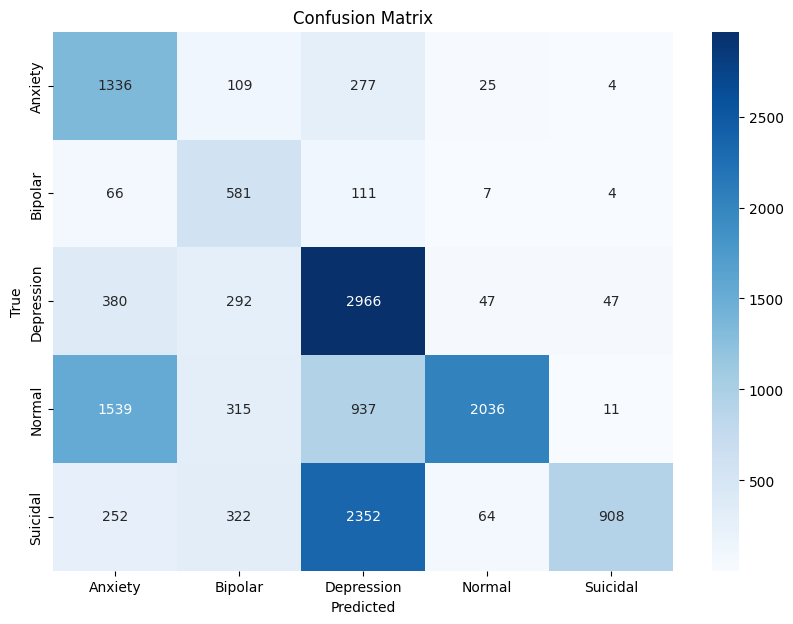

In [248]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=20000)  # Limit vocabulary size to 10000
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Feature Selection using SelectKBest with chi2 score
k_best = 10000  # Select top 5000 features
selector = SelectKBest(score_func=chi2, k=k_best)
X_train_selected = selector.fit_transform(X_train_tfidf, y_train)

# Define class priors
class_priors = [0.314298, 0.265227, 0.252045, 0.118902, 0.049528]

# Define the parameter grid for GridSearchCV
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Use unigrams and/or bigrams
    'clf__alpha': [0.1, 0.5, 1.0],  # Smoothing parameter for Naive Bayes
    'clf__fit_prior': [True]  # Whether to learn class prior probabilities or use the ones provided
}

# Create a pipeline that first transforms data using TF-IDF and then applies Naive Bayes
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000)),  # Placeholder for TF-IDF Vectorizer
    ('feature_selection', SelectKBest(score_func=chi2, k=10000)),
    ('clf', MultinomialNB(class_prior=class_priors))  # Naive Bayes with class priors
])

# Initialize GridSearchCV with timeout for joblib workers
timeout_in_seconds = 300  # Timeout set to 5 minutes (300 seconds)
with parallel_backend('loky'):
    grid_search = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=5,  # Number of folds for cross-validation
        scoring='f1_weighted',  # F1 score, weighted for imbalanced classes
        verbose=1,  # Print progress
        n_jobs=-1  # Use all available cores
    )

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # After fitting, now you can access best parameters and scores
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best F1 score: {grid_search.best_score_}")

    # Evaluate on the test set
    best_model = grid_search.best_estimator_
    test_score = best_model.score(X_test, y_test)
    print(f"Test set score: {test_score}")

# Assuming best_model is your best estimator from GridSearchCV
tfidf_vectorizer = best_model.named_steps['tfidf']
X_train_tfidf = tfidf_vectorizer.transform(X_train)

# Inspect the shape of the transformed feature matrix
print(f"Shape of X_train_tfidf: {X_train_tfidf.shape}")

# Generate predictions on the test set
y_pred = best_model.predict(X_test)

# Print classification report
report = classification_report(y_test, y_pred, target_names=best_model.classes_)
print("Classification Report:\n", report)

# Optionally, print confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Our F1-Scores improved slightly...but parts of our confusion matrix actually got *worse*! How!?!? Why!! 

Let's see what happens if we drop Normal altogether.

In [249]:
filtered_df['status'].value_counts()

status
Normal        15829
Suicidal      13173
Depression    12546
Anxiety        5909
Bipolar        2501
Name: count, dtype: int64

## Experiment: Dropping Normal

We'll test new numbers for SelectKBest and Max_Features now that we have a considerable amount fewer rows.

In [250]:
test_df = filtered_df

# Drop rows where 'status' is 'Normal'
test_df = test_df[test_df['status'] != 'Normal']

In [251]:
# Define features and target
X = test_df['joined_tokens']
y = test_df['status']  # 'status' is the target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Assuming `y_train` contains the target labels
class_distribution = y_train.value_counts(normalize=True)
class_distribution

status
Suicidal      0.384554
Depression    0.367560
Anxiety       0.176769
Bipolar       0.071118
Name: proportion, dtype: float64

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'clf__alpha': 0.1, 'clf__fit_prior': True, 'feature_selection__k': 5000, 'tfidf__ngram_range': (1, 2)}
Best F1 score: 0.5683273337747731
Test set score: 0.5733958394374451
Shape of X_train_tfidf: (23890, 10000)
Classification Report:
               precision    recall  f1-score   support

     Anxiety       0.56      0.82      0.67      1686
     Bipolar       0.32      0.85      0.46       802
  Depression       0.58      0.61      0.60      3765
    Suicidal       0.90      0.38      0.53      3986

    accuracy                           0.57     10239
   macro avg       0.59      0.67      0.56     10239
weighted avg       0.68      0.57      0.57     10239



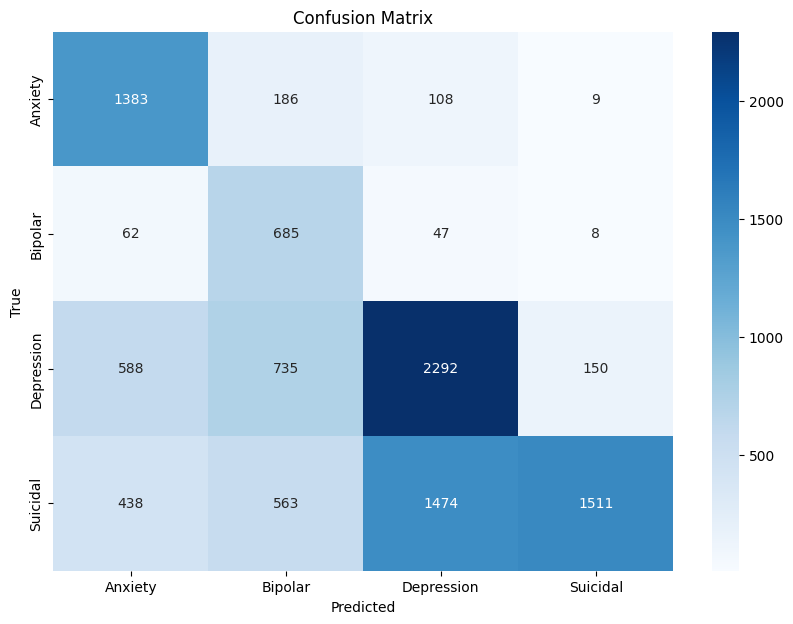

In [252]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=20000)  # Limit vocabulary size to 10000
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Feature Selection using SelectKBest with chi2 score
k_best = 10000  # Select top 5000 features
selector = SelectKBest(score_func=chi2, k=k_best)
X_train_selected = selector.fit_transform(X_train_tfidf, y_train)

# Define class priors
class_priors = [0.384554, 0.367560, 0.176769, 0.071118]

param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Use unigrams and/or bigrams
    'feature_selection__k': [2000, 5000],  # Adjusted values for feature selection
    'clf__alpha': [0.1, 0.5, 1.0],  # Smoothing parameter for Naive Bayes
    'clf__fit_prior': [True]  # Whether to learn class prior probabilities or use the ones provided
}


# Create a pipeline that first transforms data using TF-IDF and then applies Naive Bayes
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000)),  # Placeholder for TF-IDF Vectorizer
    ('feature_selection', SelectKBest(score_func=chi2, k=5000)),
    ('clf', MultinomialNB(class_prior=class_priors))  # Naive Bayes with class priors
])

# Initialize GridSearchCV with timeout for joblib workers
timeout_in_seconds = 300  # Timeout set to 5 minutes (300 seconds)
with parallel_backend('loky'):
    grid_search = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=5,  # Number of folds for cross-validation
        scoring='f1_weighted',  # F1 score, weighted for imbalanced classes
        verbose=1,  # Print progress
        n_jobs=-1  # Use all available cores
    )

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # After fitting, now you can access best parameters and scores
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best F1 score: {grid_search.best_score_}")

    # Evaluate on the test set
    best_model = grid_search.best_estimator_
    test_score = best_model.score(X_test, y_test)
    print(f"Test set score: {test_score}")

# Assuming best_model is your best estimator from GridSearchCV
tfidf_vectorizer = best_model.named_steps['tfidf']
X_train_tfidf = tfidf_vectorizer.transform(X_train)

# Inspect the shape of the transformed feature matrix
print(f"Shape of X_train_tfidf: {X_train_tfidf.shape}")

# Generate predictions on the test set
y_pred = best_model.predict(X_test)

# Print classification report
report = classification_report(y_test, y_pred, target_names=best_model.classes_)
print("Classification Report:\n", report)

# Optionally, print confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Multinomial Logistic Regression

We tried running it, and it's still taking awhile. We're going to refrain from using SelectFromModel with Random Forest to select features...to try and cut down on runtime further. Especially now that we have honed some of our dataset.

X = filtered_df.drop(columns=['status', 'tokens'])
y = filtered_df['status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)
y_train = pd.Series(y_train_encoded)
y_test = pd.Series(y_test_encoded)

# Check encoded labels
print("Encoded y_train:")
print(y_train.value_counts())

print("Encoded y_test:")
print(y_test.value_counts())

# Mapping from encoded labels to original labels
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Label Mapping:")
print(label_mapping)

vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 2))

X_train_text = vectorizer.fit_transform(X_train['joined_tokens'])
X_test_text = vectorizer.transform(X_test['joined_tokens'])

# Scale numeric data
# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform StandardScaler on numeric data
# ADDING NEW WORD COUNT FEATURE
X_train_numeric_scaled = scaler.fit_transform(X_train[['perc_upper_words', 'neg_emoji', 'exclamation_count', 'question_count', 'word_count']])
X_test_numeric_scaled = scaler.transform(X_test[['perc_upper_words', 'neg_emoji', 'exclamation_count', 'question_count', 'word_count']])

X_train_combined = hstack([X_train_text, X_train_numeric_scaled])
X_test_combined = hstack([X_test_text, X_test_numeric_scaled])

param_grid = {
    'clf__C': [0.1, 1.0, 10.0],
    'clf__solver': ['lbfgs', 'saga'],
    'clf__max_iter': [2000], # Balance computational cost with covergence needs for max_iter
}

# Logistic Regression
pipeline = Pipeline([
    ('clf', LogisticRegression(class_weight='balanced', random_state=42)), # Removed multi_class to account for warning, multinomial is default
])

# Initialize GridSearchCV
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5,
    scoring='f1_weighted',
    verbose=0,
    n_jobs=-1,
)

# Fit GridSearchCV
grid_search.fit(X_train_combined, y_train)

# Evaluate on the test set
test_score = grid_search.score(X_test_combined, y_test)
print(f"Test set score: {test_score}")

print("Best parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

# Random Forest

Let's try building a Random Forest model, which is known to handle non-linear complex relationships in large datasets quite well. Yet is less computationally expensive than a model like Gradient Boosting.

We will not need to use a Label Encoder or Standard Scaler for Random Forest.

X = filtered_df.drop(columns=['status', 'tokens'])
y = filtered_df['status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 2))

X_train_text = vectorizer.fit_transform(X_train['joined_tokens'])
X_test_text = vectorizer.transform(X_test['joined_tokens'])

X_train_numeric = X_train[['perc_upper_words', 'neg_emoji', 'exclamation_count', 'question_count', 'word_count']].values
X_test_numeric = X_test[['perc_upper_words', 'neg_emoji', 'exclamation_count', 'question_count', 'word_count']].values

X_train_combined = hstack([X_train_text, X_train_numeric])
X_test_combined = hstack([X_test_text, X_test_numeric])

In [ ]:
param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
}

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced')),
])

@profile
def run_grid_search():
    with parallel_backend('loky'):
        grid_search = GridSearchCV(
            pipeline,
            param_grid,
            cv=5,
            scoring='f1_weighted',
            verbose=0,
            n_jobs=-1,
        )

        # Fit GridSearchCV
        grid_search.fit(X_train_combined, y_train)

        # Evaluate on the test set
        test_score = grid_search.score(X_test_combined, y_test)
        print(f"Test set score: {test_score}")

        print("Best parameters:", grid_search.best_params_)
        print("Best F1 score:", grid_search.best_score_)

if __name__ == "__main__":
    run_grid_search()

In [ ]:
with parallel_backend('loky'):
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='f1_weighted',
        verbose=0,
        n_jobs=-1,
    )

    # Fit GridSearchCV
    grid_search.fit(X_train_combined, y_train)

    # Evaluate on the test set
    test_score = grid_search.score(X_test_combined, y_test)
    print(f"Test set score: {test_score}")

    print("Best parameters:", grid_search.best_params_)
    print("Best F1 score:", grid_search.best_score_)

# XGBoost

Let's try XGBoost, which is known to yield extraodinary results on large, complex datasets that require multi-categorical targets.

Let's train, test, split.

We can **include our numeric features** this time, in addition to our text data which will be vectorized.

# Define features and target
X = filtered_df.drop(columns=['status', 'tokens'])
y = filtered_df['status']  # 'status' is the target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

#### LabelEncoder()

We need to use LabelEncoder() to make sure we have correctly formatted indices for XGBoost, starting at '0'.

y_train.value_counts().sort_index()

# Instantiate the encoder
encoder = LabelEncoder()

# Fit the encoder on y_train and transform it
y_train_encoded = encoder.fit_transform(y_train)

# Transform y_test based on the encoder fitted on y_train
y_test_encoded = encoder.transform(y_test)

# Convert back to pandas Series
y_train = pd.Series(y_train_encoded)
y_test = pd.Series(y_test_encoded)

# Check encoded labels
print("Encoded y_train:")
print(y_train.value_counts())

print("Encoded y_test:")
print(y_test.value_counts())

# Mapping from encoded labels to original labels
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

print("Label Mapping:")
label_mapping

### Vectorize - TF-IDF

We need to vectorize our 'joined_tokens' again.

# Step 1: Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 2))

# Step 2: Transform text data
X_train_text = vectorizer.fit_transform(X_train['joined_tokens'])
X_test_text = vectorizer.transform(X_test['joined_tokens'])

X_train_numeric = X_train.drop(columns=['joined_tokens'])
X_test_numeric = X_test.drop(columns=['joined_tokens'])

X_train_numeric = X_train[['perc_upper_words', 'neg_emoji', 'exclamation_count', 'question_count']].values
X_test_numeric = X_test[['perc_upper_words', 'neg_emoji', 'exclamation_count', 'question_count']].values

# Step 3: Combine text and numeric features (if applicable)
# Assuming X_train_numeric and X_test_numeric are your numeric features
X_train_combined = hstack([X_train_text, X_train_numeric])
X_test_combined = hstack([X_test_text, X_test_numeric])

### Best Parameters - GridSearchCV

There are so many parameters we can test for...but we'll want to limit the number we run through GridSearchCV to cut down on computational cost. 

# Define the parameter grid
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# Initialize XGBClassifier
xgb_model = XGBClassifier(objective='multi:softmax', num_class=7, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1_weighted',  # Use F1 score to account for class imbalance
    cv=5,  # Number of cross-validation folds
    verbose=0,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train_combined, y_train)

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best F1 score: {grid_search.best_score_}")

# Evaluate on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print(f"Test set score: {test_score}")

# Convert numerical features to sparse matrix format
X_train_numerical = csr_matrix(X_train.drop(columns=['joined_tokens']).values)
X_test_numerical = csr_matrix(X_test.drop(columns=['joined_tokens']).values)

# Combine TF-IDF features with numerical features
X_train_combined = hstack([X_train_text, X_train_numerical])
X_test_combined = hstack([X_test_text, X_test_numerical])

In [ ]:
filtered_df['status'].value_counts()

# Graphs For Presentation

In [ ]:
# Calculate mean exclamation_count for each status group
mean_counts = filtered_df.groupby('status')['exclamation_count'].mean().reset_index()

# Assuming mean_counts is your DataFrame with mean exclamation counts for each status
mean_counts = mean_counts.sort_values(by='exclamation_count')


# Define custom colors for specific status groups
status_colors = {
    'Bipolar': '#8dd8d3',    # Turqoise
    'Depression': '#69c6ef',    # Light Blue
    'Suicidal': '#d7e6a3',    # Light Green
    'Anxiety': '#df6fba',    # Pink
    'Normal': '#e4a959'     # Orange
}

# Plotting bar graph with custom colors
plt.figure(figsize=(10, 6))
sns.barplot(x='status', y='exclamation_count', data=mean_counts, palette=status_colors.values())
plt.title('Mean Exclamation Count by Status', color='white')  # Set title color to white
plt.xlabel('Status', color='white')  # Set x-axis label color to white
plt.ylabel('Mean Exclamation Count', color='white')  # Set y-axis label color to white
plt.xticks(color='white')  # Set x-axis tick label color to white
plt.yticks(color='white')  # Set y-axis tick label color to white
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if necessary
plt.gca().spines['top'].set_color('none')  # Remove top spine
plt.gca().spines['right'].set_color('none')  # Remove right spine
plt.gca().spines['left'].set_color('white')  # Set left spine color to white
plt.gca().spines['bottom'].set_color('white')  # Set bottom spine color to white
plt.tight_layout()
plt.savefig('mean_exclamation_count_by_status.png', transparent=True)  # Save with transparent background
plt.show()

In [ ]:
# Define custom colors for specific status groups
status_colors = {
    'Bipolar': '#8dd8d3',    # Turqoise
    'Depression': '#69c6ef',    # Light Blue
    'Suicidal': '#d7e6a3',    # Light Green
    'Anxiety': '#df6fba',    # Pink
    'Normal': '#e4a959'     # Orange
}

# Calculate mean exclamation_count for each status group
mean_counts = filtered_df.groupby('status')['exclamation_count'].mean().reset_index()

# Assuming mean_counts is your DataFrame with mean exclamation counts for each status
mean_counts = mean_counts.sort_values(by='exclamation_count')

# Plotting bar graph with custom colors
plt.figure(figsize=(10, 6))
sns.barplot(x='status', y='exclamation_count', data=mean_counts,
            palette=status_colors)  # Use palette argument to assign colors
plt.title('Mean Exclamation Count by Status', color='white')  # Set title color to white
plt.xlabel('Status', color='white')  # Set x-axis label color to white
plt.ylabel('Mean Exclamation Count', color='white')  # Set y-axis label color to white
plt.xticks(color='white')  # Set x-axis tick label color to white
plt.yticks(color='white')  # Set y-axis tick label color to white
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if necessary
plt.gca().spines['top'].set_color('none')  # Remove top spine
plt.gca().spines['right'].set_color('none')  # Remove right spine
plt.gca().spines['left'].set_color('white')  # Set left spine color to white
plt.gca().spines['bottom'].set_color('white')  # Set bottom spine color to white
plt.tight_layout()
plt.savefig('mean_exc_count_by_status.png', transparent=True)  # Save with transparent background
plt.show()

In [ ]:
# Define custom colors for specific status groups
status_colors = {
    'Bipolar': '#8dd8d3',    # Turqoise
    'Depression': '#69c6ef',    # Light Blue
    'Suicidal': '#d7e6a3',    # Light Green
    'Anxiety': '#df6fba',    # Pink
    'Normal': '#e4a959'     # Orange
}

# Calculate mean exclamation_count for each status group
mean_counts = filtered_df.groupby('status')['word_count'].mean().reset_index()

# Assuming mean_counts is your DataFrame with mean exclamation counts for each status
mean_counts = mean_counts.sort_values(by='word_count')

# Plotting bar graph with custom colors
plt.figure(figsize=(10, 6))
sns.barplot(x='status', y='word_count', data=mean_counts,
            palette=status_colors)  # Use palette argument to assign colors
plt.title('Mean Word Count by Status', color='white')  # Set title color to white
plt.xlabel('Status', color='white')  # Set x-axis label color to white
plt.ylabel('Mean Word Count', color='white')  # Set y-axis label color to white
plt.xticks(color='white')  # Set x-axis tick label color to white
plt.yticks(color='white')  # Set y-axis tick label color to white
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if necessary
plt.gca().spines['top'].set_color('none')  # Remove top spine
plt.gca().spines['right'].set_color('none')  # Remove right spine
plt.gca().spines['left'].set_color('white')  # Set left spine color to white
plt.gca().spines['bottom'].set_color('white')  # Set bottom spine color to white
plt.tight_layout()
plt.savefig('mean_word_count_by_status.png', transparent=True)  # Save with transparent background
plt.show()

In [ ]:
mean_counts

In [ ]:
filtered_df['status'].value_counts()

In [ ]:
# Create a legend with custom colors
legend_handles = [plt.Line2D([0, 1], [0, 0], color=color, linewidth=10, linestyle='-') for status, color in status_colors.items()]
legend_labels = list(status_colors.keys())

# Plot the legend
plt.figure(figsize=(8, 2))
legend = plt.legend(legend_handles, legend_labels, loc='center', frameon=False, ncol=len(legend_labels))
plt.axis('off')

# Set legend text color to white
for text in legend.get_texts():
    text.set_color('white')

# Save the legend with transparent background
plt.savefig('legend.png', transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()